In [58]:
#import all packages
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np

In [59]:
# Load JSON data from file
with open('new_measurements.json', 'r') as file:
    data_dict = json.load(file)

In [60]:
# Set average sunrise and sunset times for early May
sunrise = pd.to_datetime('05:30:00').time()
sunset = pd.to_datetime('20:00:00').time()

In [61]:
def process_sensor_data(sensor, sunrise, sunset):
    tid = sensor['tid']

    # Create DataFrame for the sensor
    df = pd.DataFrame({
        'timestamp': sensor['timestamps'],
        'voltage': sensor['values']
    })

    # Convert timestamp column to datetime
    df['timestamp'] = pd.to_datetime(df['timestamp'])

    # Handle missing or invalid values
    df['voltage'] = pd.to_numeric(df['voltage'], errors='coerce')

    # Calculate number of empty values before dropping for analysis
    empty_values_count = df['voltage'].isna().sum()

    # Delte empty values
    df = df.dropna()

    # Calculate intit row count
    initial_row_count = df.shape[0]

    # Calculate mean voltage
    mean_voltage = df['voltage'].mean()

    # Define outliers as values more than 20% above or below the average
    lower_bound = mean_voltage * 0.8
    upper_bound = mean_voltage * 1.2

    # Remove outliers
    df = df[(df['voltage'] >= lower_bound) & (df['voltage'] <= upper_bound)]

    # Calculate number of outliers removed
    outliers_removed = initial_row_count - df.shape[0]

    # Check if data point is during daylight hours
    df['is_daylight'] = df['timestamp'].dt.time.between(sunrise, sunset)

    # Calculate moving averages
    df['moving_avg_5'] = df['voltage'].rolling(window=5).mean()
    df['moving_avg_15'] = df['voltage'].rolling(window=15).mean()

    # Find peak and low voltage times
    peak_voltage_times = df[df['voltage'] == df['voltage'].max()][['timestamp', 'voltage']]
    low_voltage_times = df[df['voltage'] == df['voltage'].min()][['timestamp', 'voltage']]

    # Check potential anomalies (values that are significantly different from moving average)
    df['anomaly'] = np.where((df['voltage'] > df['moving_avg_15'] * 1.5) | (df['voltage'] < df['moving_avg_15'] * 0.5), True, False)

    anomalies_count = df['anomaly'].sum()

    # Calculate the number of rows after processing
    final_row_count = df.shape[0]

    # Calculate the mean and standard deviation
    mean_voltage = df['voltage'].mean()
    std_dev = df['voltage'].std()

    return df, tid, peak_voltage_times, low_voltage_times, empty_values_count, outliers_removed, anomalies_count, final_row_count, mean_voltage, std_dev

In [62]:
def plot_time_series(df, tid):
    # Plot time series
    plt.figure(figsize=(14, 7))
    plt.plot(df['timestamp'], df['voltage'], label='Voltage')
    plt.plot(df['timestamp'], df['moving_avg_5'], label='5-Point Moving Average', color='orange')
    plt.plot(df['timestamp'], df['moving_avg_15'], label='15-Point Moving Average', color='red')
    plt.scatter(df[df['anomaly']]['timestamp'], df[df['anomaly']]['voltage'], color='red', label='Anomalies')
    plt.title(f'Voltage Sensor {tid} Time Series')
    plt.xlabel('Timestamp')
    plt.ylabel('Voltage')
    plt.legend()
    plt.show()

In [63]:
def plot_trends(df, tid):
    # Trends detection (minutely, hourly, daily)
    df['minute'] = df['timestamp'].dt.minute
    df['hour'] = df['timestamp'].dt.hour
    df['day'] = df['timestamp'].dt.day

    minute_trend = df.groupby('minute')['voltage'].mean()
    hourly_trend = df.groupby('hour')['voltage'].mean()
    daily_trend = df.groupby('day')['voltage'].mean()

    # Plot trends
    plt.figure(figsize=(14, 7))
    plt.subplot(3, 1, 1)
    minute_trend.plot()
    plt.title(f'Minutely Voltage Trend for Sensor {tid}')
    plt.xlabel('Minute')
    plt.ylabel('Average Voltage')

    plt.subplot(3, 1, 2)
    hourly_trend.plot()
    plt.title(f'Hourly Voltage Trend for Sensor {tid}')
    plt.xlabel('Hour')
    plt.ylabel('Average Voltage')

    plt.subplot(3, 1, 3)
    daily_trend.plot()
    plt.title(f'Daily Voltage Trend for Sensor {tid}')
    plt.xlabel('Day')
    plt.ylabel('Average Voltage')

    plt.tight_layout()
    plt.show()

    return minute_trend, hourly_trend, daily_trend

In [64]:
def analyze_voltage(df, tid, peak_voltage_times, low_voltage_times):
    # Analyze voltage during daylight vs. nighttime
    daylight_voltage = df[df['is_daylight'] == True]['voltage'].mean()
    nighttime_voltage = df[df['is_daylight'] == False]['voltage'].mean()

    print(f"Average Voltage During Daylight for Sensor {tid}: {daylight_voltage:.2f}")
    print(f"Average Voltage During Nighttime for Sensor {tid}: {nighttime_voltage:.2f}")

    # Print peak and low voltage times with voltages
    print(f"Peak Voltage Times and Values for Sensor {tid}:\n", peak_voltage_times)
    print(f"Low Voltage Times and Values for Sensor {tid}:\n", low_voltage_times)

    return daylight_voltage, nighttime_voltage

In [65]:
def calculate_statistics(df, tid):
    mean_value = df['voltage'].mean()
    std_dev = df['voltage'].std()

    print(f"Mean Voltage for Sensor {tid}: {mean_value:.2f}")
    print(f"Standard Deviation for Sensor {tid}: {std_dev:.2f}")

    return mean_value, std_dev

Sensor voltage_sensor_0:
Number of Rows of Data: 23962
Number of Empty Values Removed: 2034
Number of Outliers Removed: 4004
Number of Potential Anomalies Detected: 0


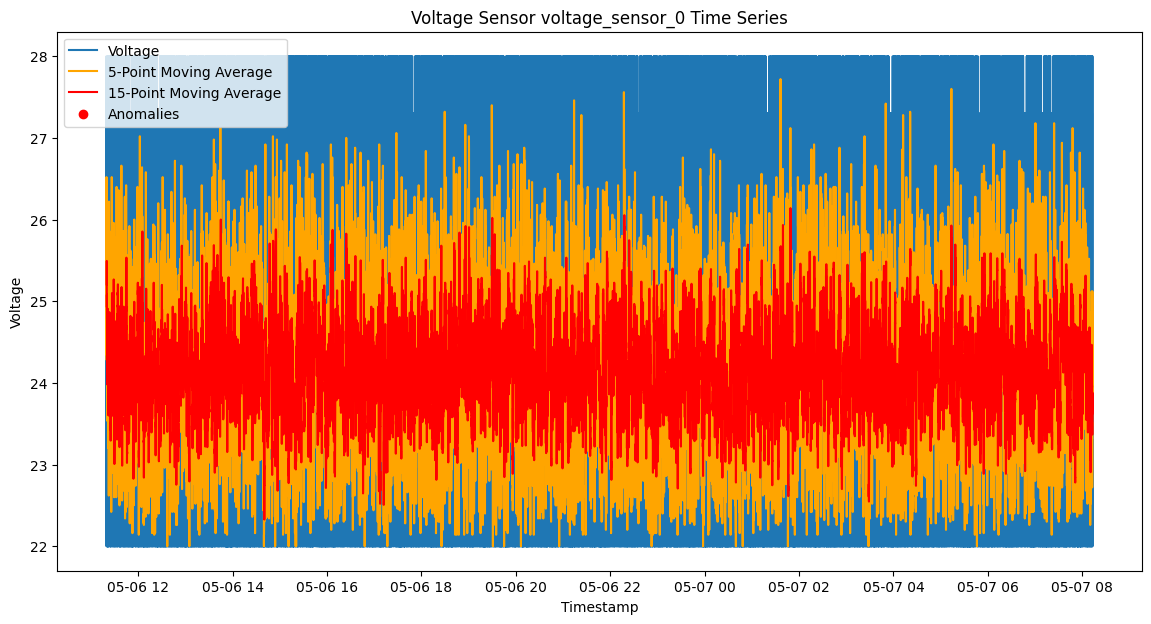

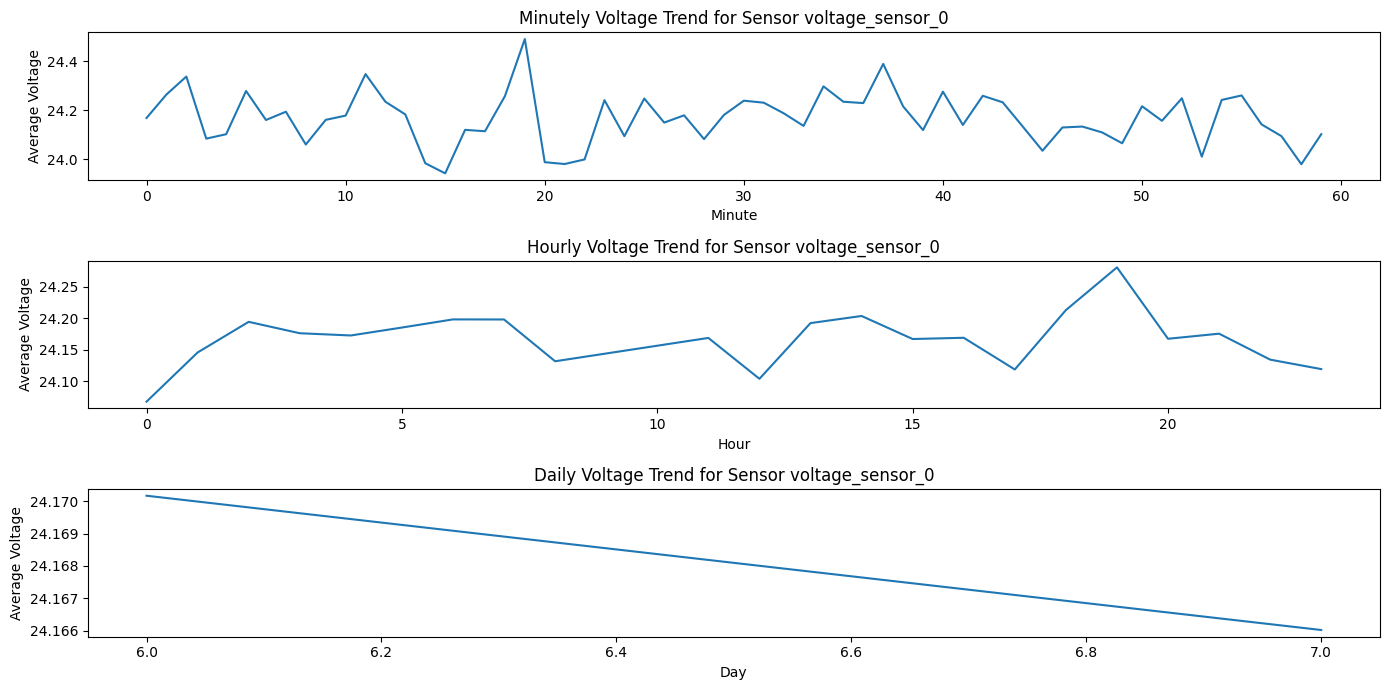

Minutely Voltage Trend for Sensor voltage_sensor_0:
 minute
0     24.168687
1     24.264649
2     24.338107
3     24.084319
4     24.102344
5     24.278986
6     24.160546
7     24.194279
8     24.060354
9     24.161055
10    24.178462
11    24.348175
12    24.235027
13    24.183120
14    23.983747
15    23.942440
16    24.120267
17    24.114504
18    24.257963
19    24.491392
20    23.988049
21    23.980542
22    23.999265
23    24.241558
24    24.094321
25    24.248309
26    24.149867
27    24.179592
28    24.082382
29    24.181122
30    24.239474
31    24.231220
32    24.187961
33    24.136341
34    24.298025
35    24.235062
36    24.229657
37    24.389781
38    24.216010
39    24.119417
40    24.276250
41    24.140247
42    24.259343
43    24.232828
44    24.134474
45    24.034925
46    24.129882
47    24.133671
48    24.109499
49    24.065455
50    24.216626
51    24.157250
52    24.249357
53    24.010670
54    24.242512
55    24.260804
56    24.142579
57    24.094550
58    23.979

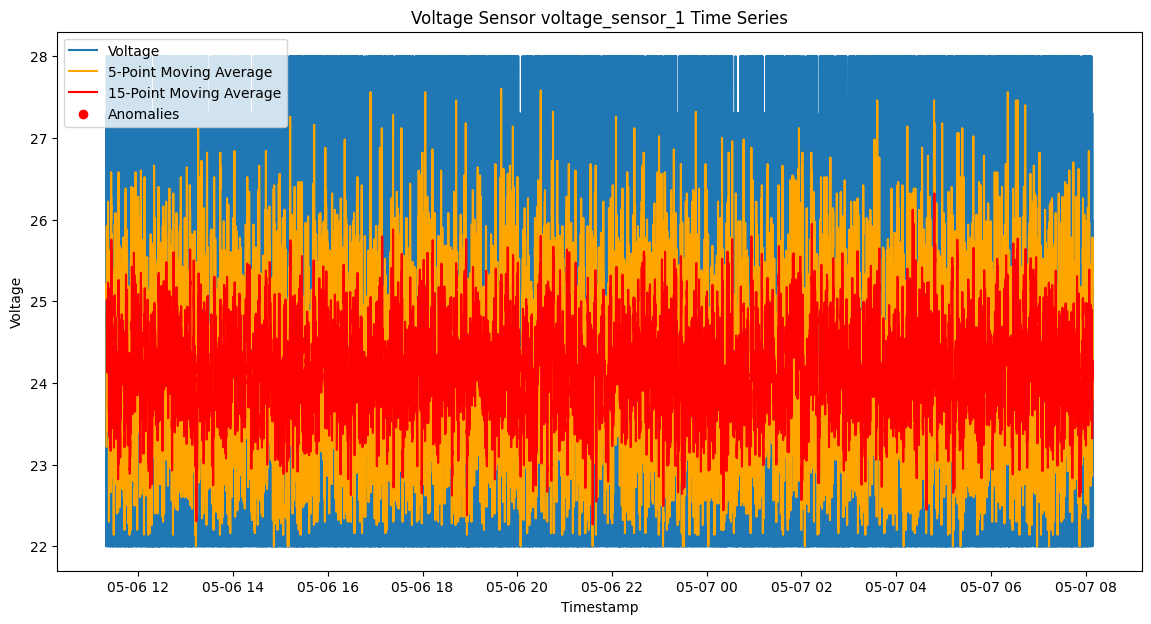

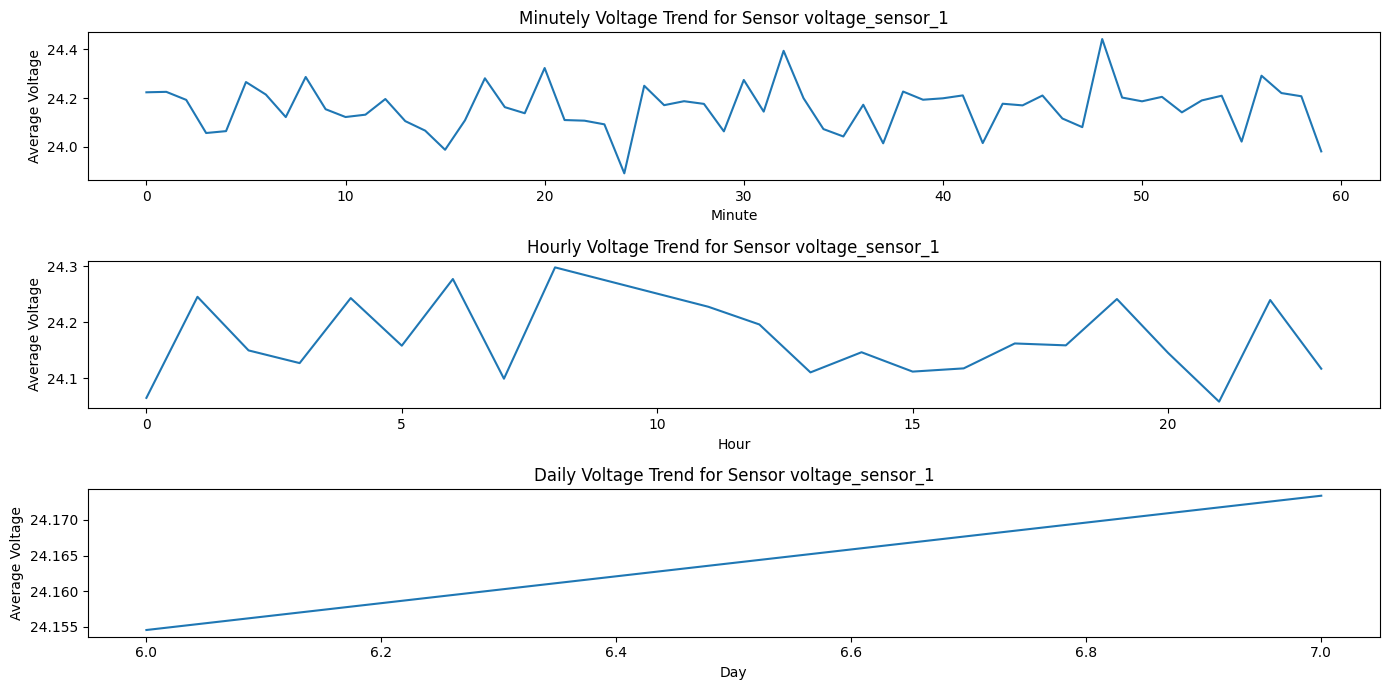

Minutely Voltage Trend for Sensor voltage_sensor_1:
 minute
0     24.223846
1     24.225700
2     24.192822
3     24.057210
4     24.064925
5     24.265860
6     24.214573
7     24.122418
8     24.286528
9     24.154617
10    24.122667
11    24.132249
12    24.196364
13    24.105867
14    24.066929
15    23.988601
16    24.109250
17    24.281186
18    24.163038
19    24.138107
20    24.323206
21    24.110294
22    24.107710
23    24.092706
24    23.892157
25    24.250594
26    24.171173
27    24.187374
28    24.176396
29    24.063934
30    24.274307
31    24.144743
32    24.393674
33    24.199746
34    24.073350
35    24.043041
36    24.172902
37    24.015013
38    24.226904
39    24.193451
40    24.199274
41    24.211139
42    24.016031
43    24.177041
44    24.170324
45    24.210680
46    24.116624
47    24.081190
48    24.441787
49    24.202338
50    24.186967
51    24.205263
52    24.141775
53    24.190585
54    24.209813
55    24.022030
56    24.291710
57    24.220716
58    24.207

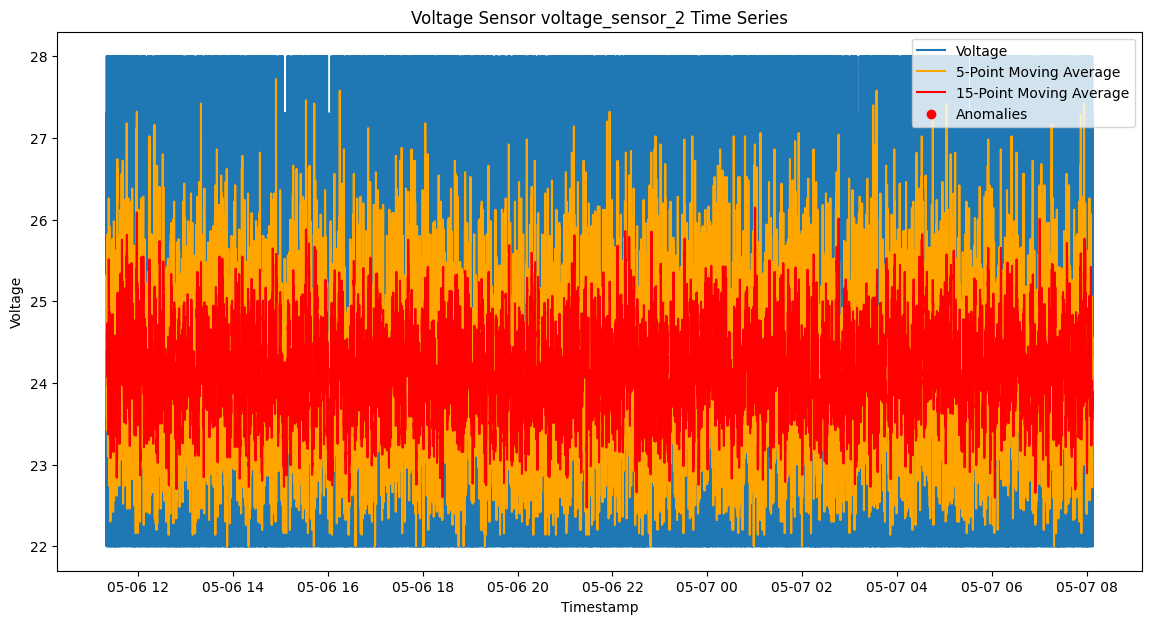

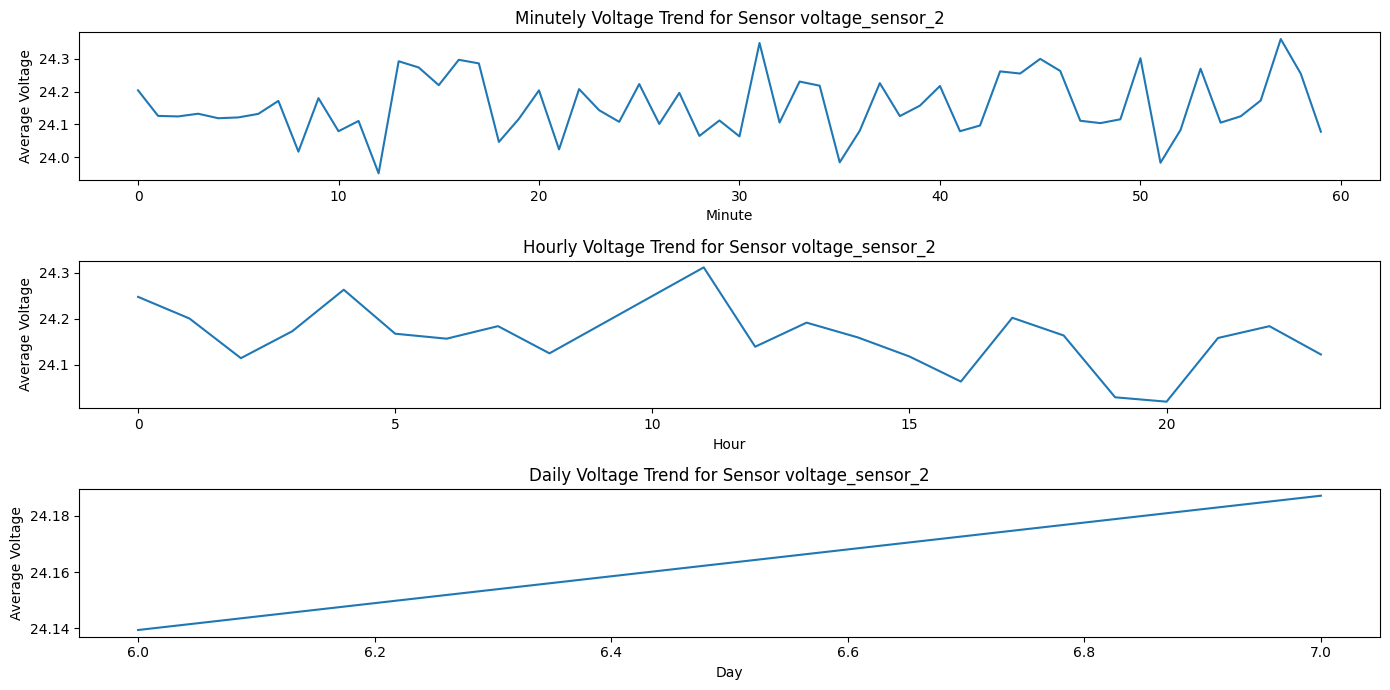

Minutely Voltage Trend for Sensor voltage_sensor_2:
 minute
0     24.203922
1     24.125990
2     24.124402
3     24.132653
4     24.118905
5     24.121394
6     24.132195
7     24.171734
8     24.017112
9     24.180055
10    24.079373
11    24.110569
12    23.951036
13    24.292487
14    24.273537
15    24.219656
16    24.296939
17    24.285942
18    24.046753
19    24.117327
20    24.203819
21    24.023940
22    24.207653
23    24.143325
24    24.107928
25    24.222986
26    24.101531
27    24.196196
28    24.065025
29    24.112129
30    24.063591
31    24.348101
32    24.105836
33    24.230617
34    24.218020
35    23.984579
36    24.080789
37    24.225791
38    24.125436
39    24.157176
40    24.217079
41    24.079353
42    24.096837
43    24.261596
44    24.255087
45    24.299754
46    24.262972
47    24.111222
48    24.104040
49    24.115672
50    24.301707
51    23.983290
52    24.083092
53    24.269690
54    24.105483
55    24.124814
56    24.172893
57    24.360152
58    24.254

Minutely Voltage Trend for Sensor voltage_sensor_3:
 minute
0     24.192365
1     24.139276
2     24.364232
3     24.079500
4     24.258974
5     24.236049
6     24.086165
7     24.244169
8     24.176790
9     24.321975
10    23.965087
11    24.156028
12    24.231200
13    24.189059
14    24.113661
15    24.272705
16    24.238462
17    23.958961
18    24.227807
19    24.271717
20    24.173367
21    24.110283
22    24.230467
23    24.252604
24    24.199749
25    24.143411
26    24.020899
27    24.244703
28    23.987531
29    24.093596
30    24.197487
31    24.232997
32    24.241363
33    24.159949
34    24.011675
35    24.177506
36    24.110513
37    24.070813
38    24.161519
39    24.133005
40    24.237186
41    24.196947
42    24.205172
43    24.245946
44    24.143171
45    24.032864
46    24.258122
47    24.241337
48    24.283247
49    24.175128
50    24.164051
51    24.090909
52    24.073710
53    24.141805
54    23.950390
55    24.001446
56    24.147458
57    24.324548
58    23.965

Minutely Voltage Trend for Sensor voltage_sensor_4:
 minute
0     24.152758
1     24.330266
2     24.096173
3     24.087685
4     24.154337
5     24.139348
6     24.087786
7     24.015762
8     24.384198
9     24.134293
10    24.072388
11    24.019559
12    24.238520
13    24.164359
14    24.105630
15    24.100000
16    24.136973
17    24.164675
18    24.265768
19    24.111192
20    24.334230
21    24.130713
22    24.127512
23    24.215013
24    24.301781
25    24.168171
26    24.020823
27    24.093434
28    23.964663
29    24.458603
30    24.087595
31    24.231852
32    24.024318
33    24.087470
34    24.107452
35    24.196305
36    24.326173
37    24.243902
38    24.227073
39    24.140100
40    24.204798
41    23.923278
42    24.237176
43    24.260215
44    24.315136
45    24.314573
46    24.152451
47    24.254177
48    24.184131
49    24.042233
50    24.069104
51    24.245780
52    24.219212
53    24.104040
54    24.231633
55    24.145843
56    24.172973
57    24.204988
58    24.136

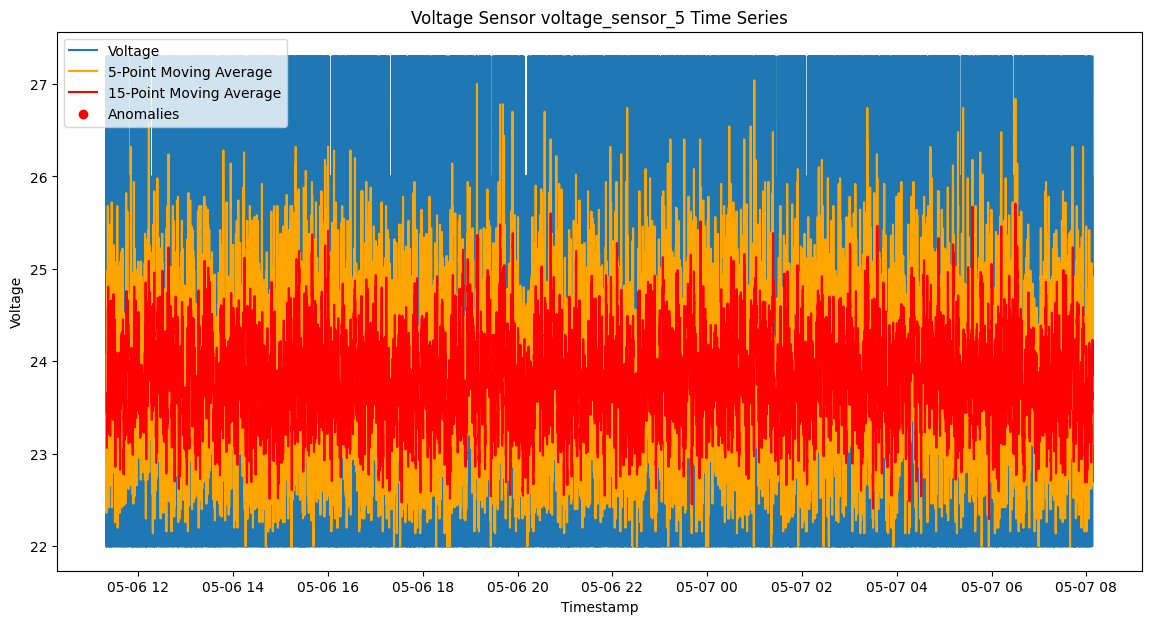

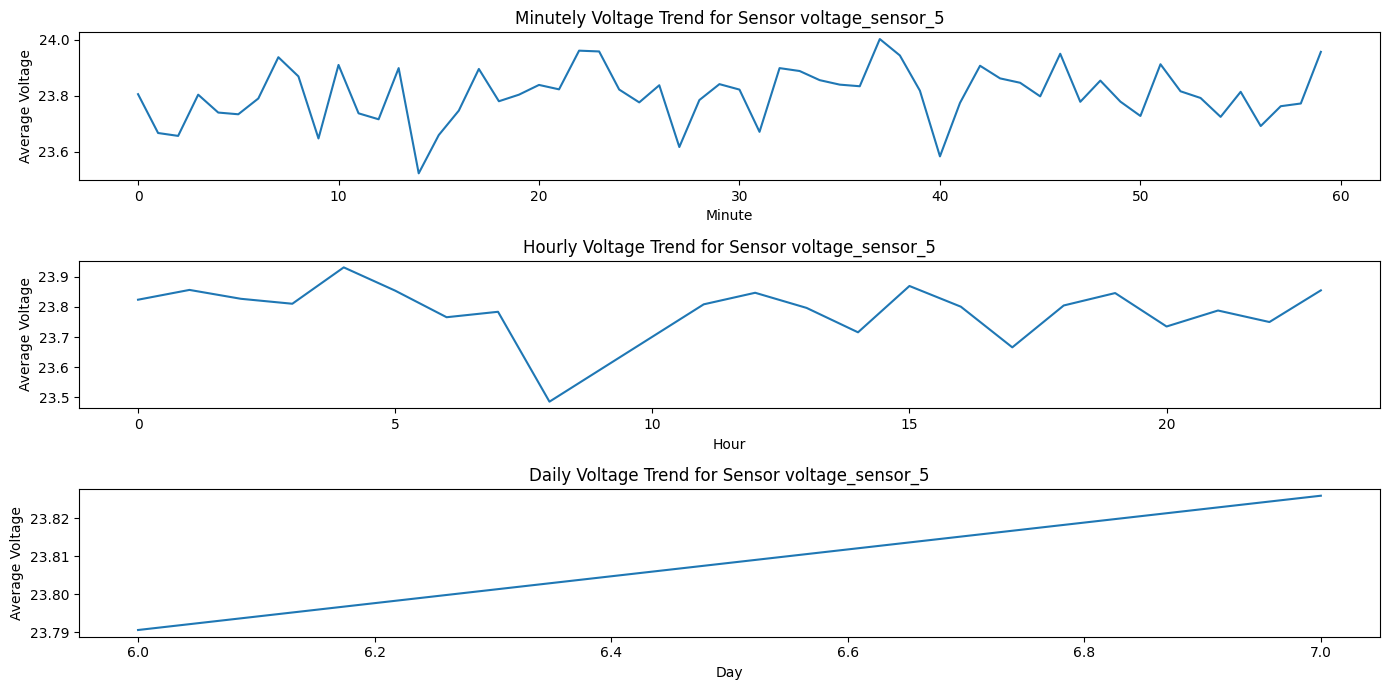

Minutely Voltage Trend for Sensor voltage_sensor_5:
 minute
0     23.804935
1     23.666396
2     23.656111
3     23.803209
4     23.739377
5     23.733239
6     23.789617
7     23.936800
8     23.868437
9     23.646978
10    23.909239
11    23.736607
12    23.715363
13    23.897953
14    23.522515
15    23.659026
16    23.746296
17    23.894955
18    23.779718
19    23.803134
20    23.837940
21    23.822161
22    23.960207
23    23.957373
24    23.821429
25    23.775645
26    23.836772
27    23.616418
28    23.783954
29    23.840782
30    23.821289
31    23.670573
32    23.897911
33    23.887599
34    23.855014
35    23.838992
36    23.833242
37    24.001622
38    23.943147
39    23.817426
40    23.583056
41    23.773842
42    23.906371
43    23.861257
44    23.845623
45    23.797172
46    23.949133
47    23.777748
48    23.853351
49    23.778385
50    23.727174
51    23.911732
52    23.815263
53    23.791365
54    23.724000
55    23.813350
56    23.691237
57    23.762022
58    23.771

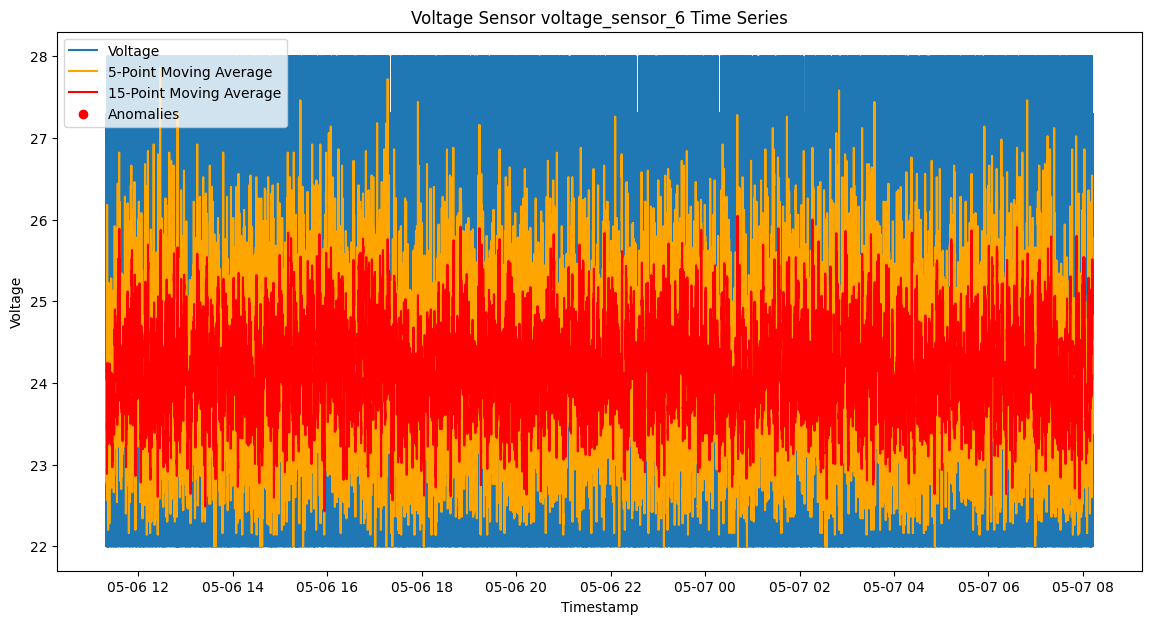

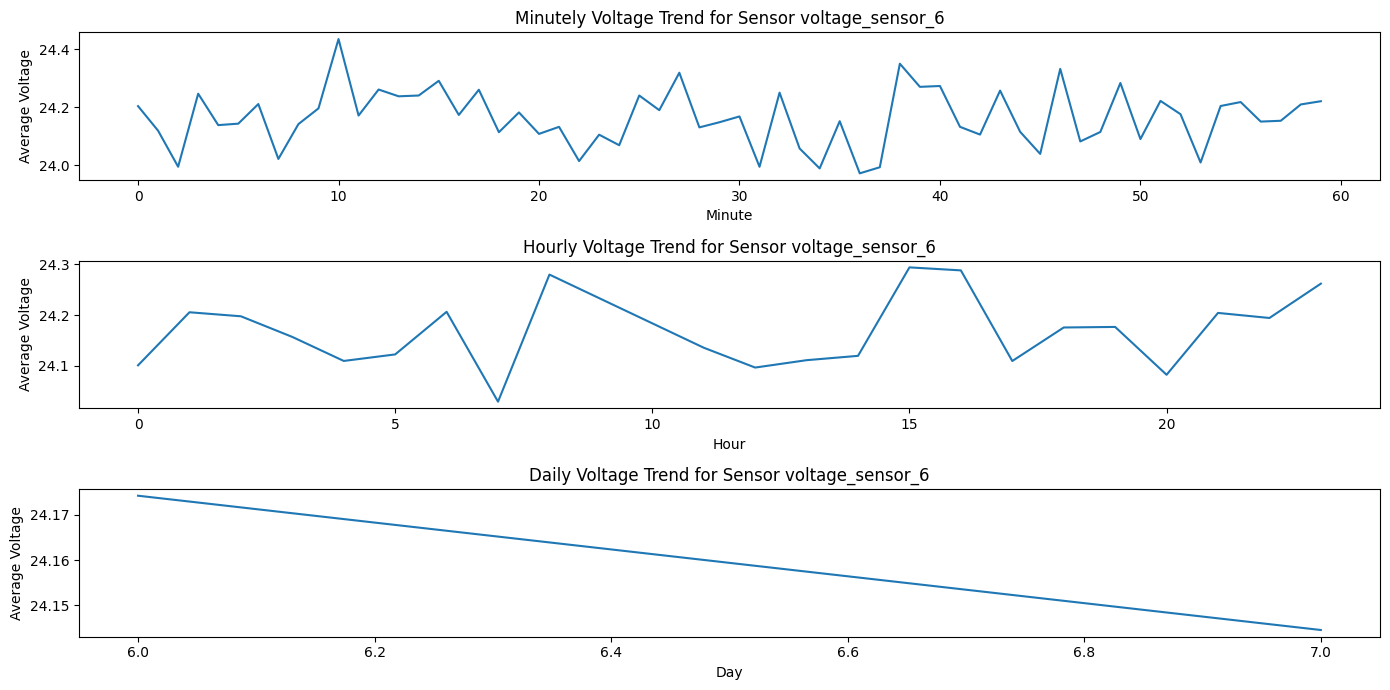

Minutely Voltage Trend for Sensor voltage_sensor_6:
 minute
0     24.203641
1     24.118719
2     23.994148
3     24.246618
4     24.138025
5     24.143045
6     24.210864
7     24.021106
8     24.141542
9     24.195823
10    24.435492
11    24.171122
12    24.261022
13    24.237596
14    24.240310
15    24.291143
16    24.173210
17    24.260260
18    24.113514
19    24.181841
20    24.107692
21    24.132029
22    24.013810
23    24.104950
24    24.068557
25    24.240365
26    24.189639
27    24.319086
28    24.130198
29    24.147942
30    24.167979
31    23.994074
32    24.250243
33    24.057248
34    23.988383
35    24.151523
36    23.971355
37    23.992435
38    24.350251
39    24.270292
40    24.273219
41    24.132048
42    24.105327
43    24.257381
44    24.114888
45    24.038537
46    24.332412
47    24.081606
48    24.114319
49    24.283575
50    24.089810
51    24.221772
52    24.175758
53    24.008816
54    24.204103
55    24.217750
56    24.150254
57    24.153030
58    24.209

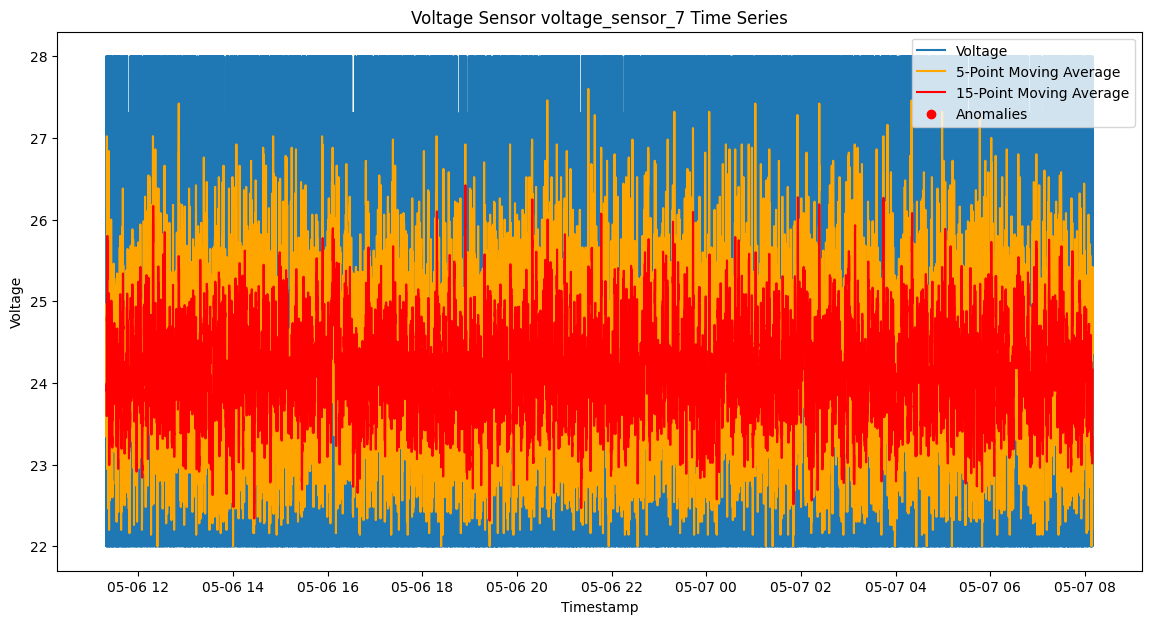

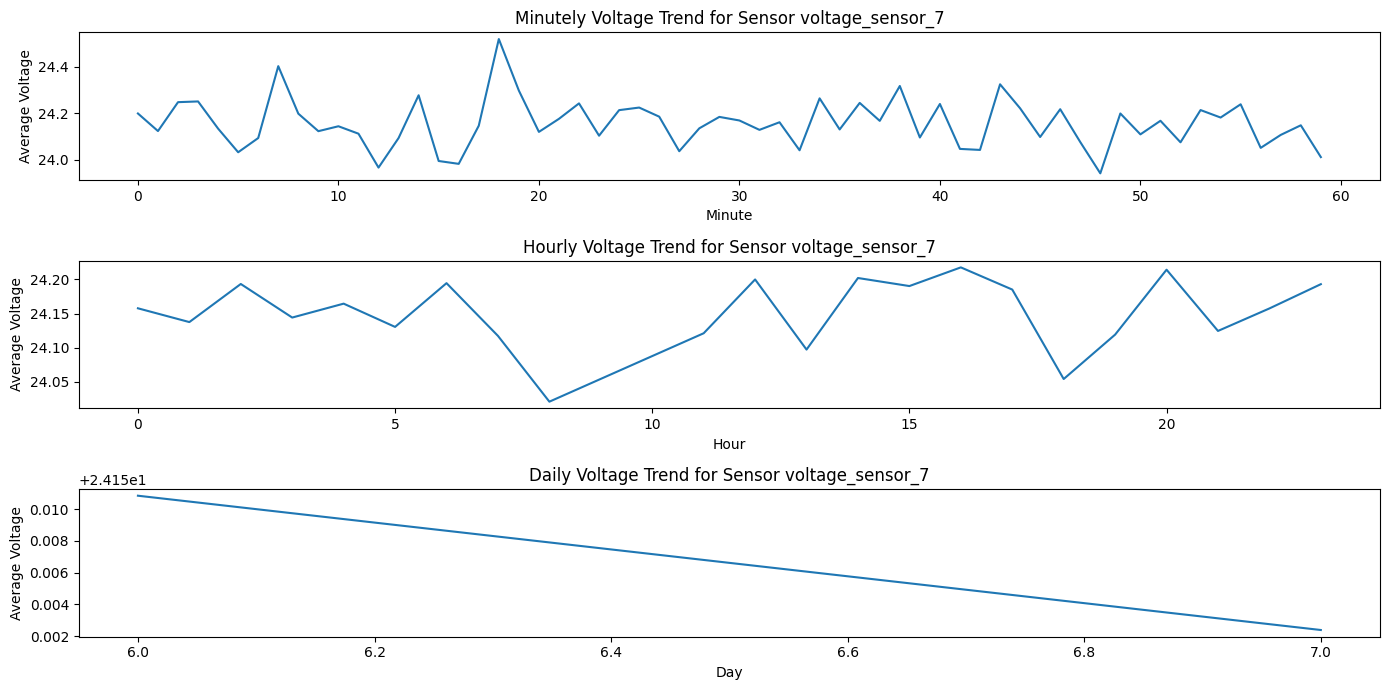

Minutely Voltage Trend for Sensor voltage_sensor_7:
 minute
0     24.199520
1     24.123846
2     24.248227
3     24.251332
4     24.134271
5     24.032648
6     24.093873
7     24.403163
8     24.198747
9     24.123377
10    24.144531
11    24.112531
12    23.966667
13    24.093767
14    24.277865
15    23.995013
16    23.982723
17    24.146835
18    24.519841
19    24.298000
20    24.120253
21    24.176486
22    24.242963
23    24.103931
24    24.213876
25    24.225000
26    24.185819
27    24.037136
28    24.135678
29    24.184819
30    24.169388
31    24.129017
32    24.161779
33    24.041147
34    24.264604
35    24.130788
36    24.244988
37    24.167711
38    24.317848
39    24.096135
40    24.240394
41    24.047074
42    24.042683
43    24.325127
44    24.221831
45    24.098293
46    24.217857
47    24.076585
48    23.941902
49    24.199499
50    24.109620
51    24.168090
52    24.075426
53    24.214214
54    24.182039
55    24.239098
56    24.051493
57    24.107317
58    24.148

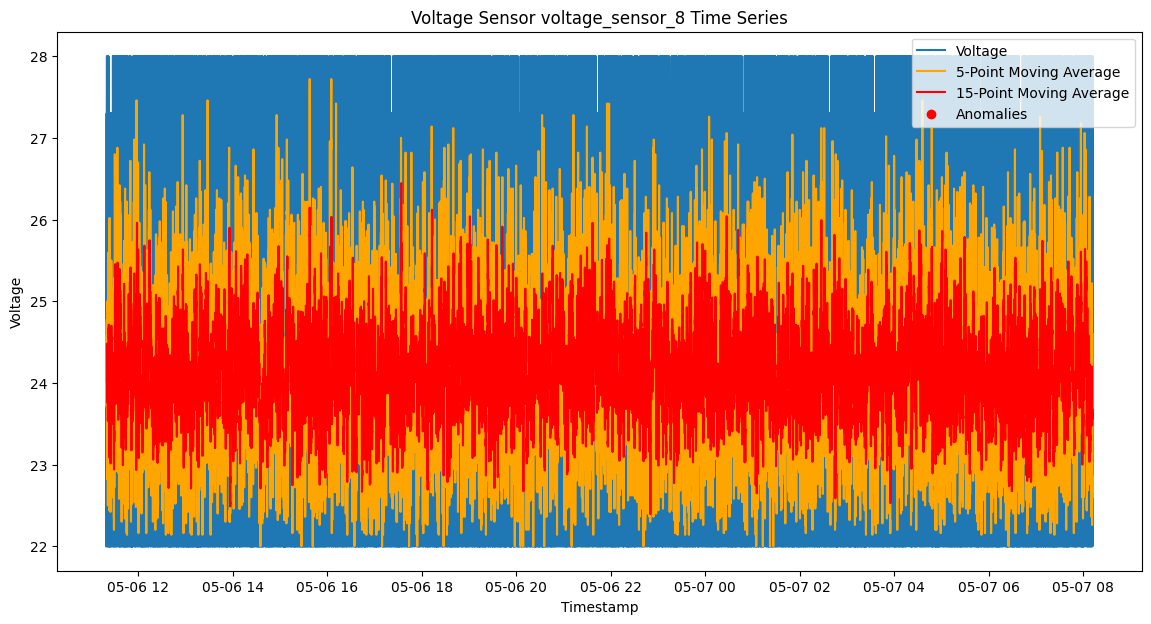

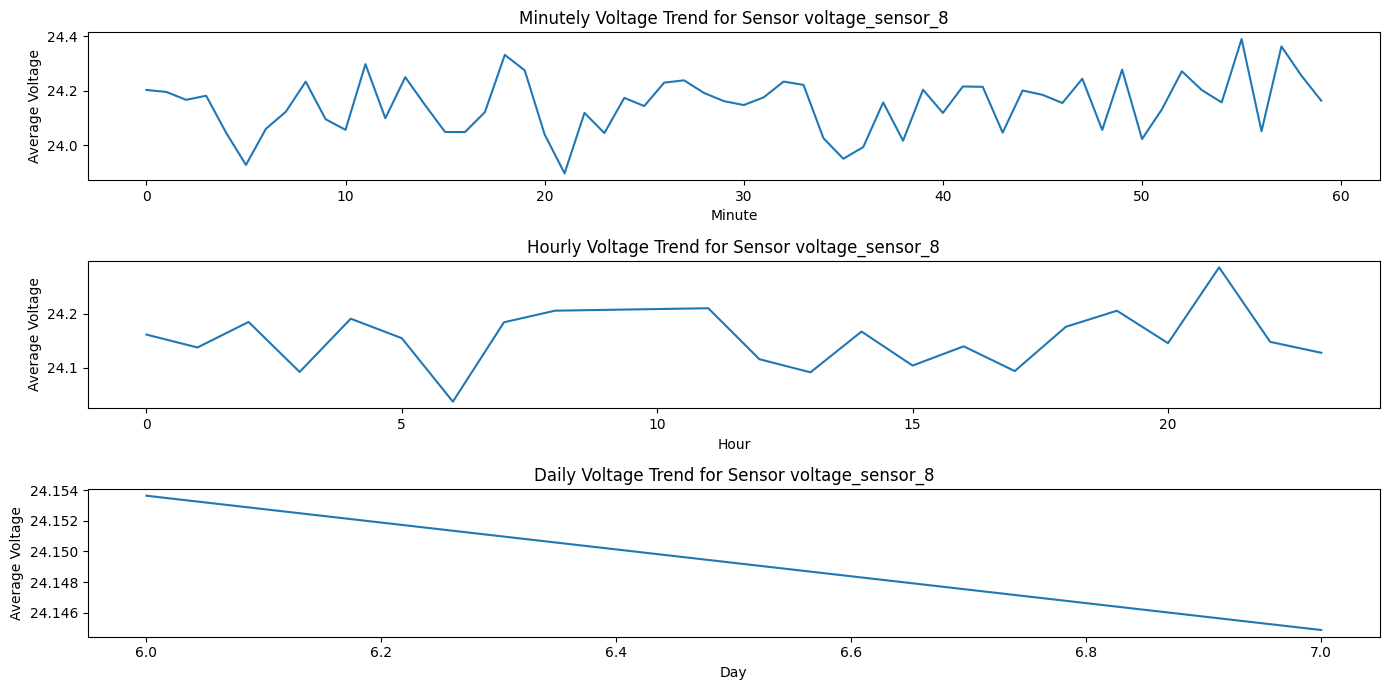

Minutely Voltage Trend for Sensor voltage_sensor_8:
 minute
0     24.203210
1     24.195970
2     24.167053
3     24.182134
4     24.047086
5     23.928822
6     24.060750
7     24.123325
8     24.233671
9     24.096030
10    24.057243
11    24.297710
12    24.099747
13    24.250000
14    24.147480
15    24.049340
16    24.049077
17    24.122025
18    24.331646
19    24.275000
20    24.040299
21    23.897980
22    24.119212
23    24.045390
24    24.174334
25    24.144258
26    24.230025
27    24.238481
28    24.192439
29    24.162383
30    24.147938
31    24.176190
32    24.233831
33    24.221823
34    24.026764
35    23.951282
36    23.994203
37    24.157568
38    24.017500
39    24.204092
40    24.119144
41    24.216000
42    24.214684
43    24.047044
44    24.201205
45    24.185507
46    24.155528
47    24.244282
48    24.056771
49    24.277551
50    24.023529
51    24.132653
52    24.271608
53    24.202948
54    24.157711
55    24.389630
56    24.052073
57    24.362654
58    24.255

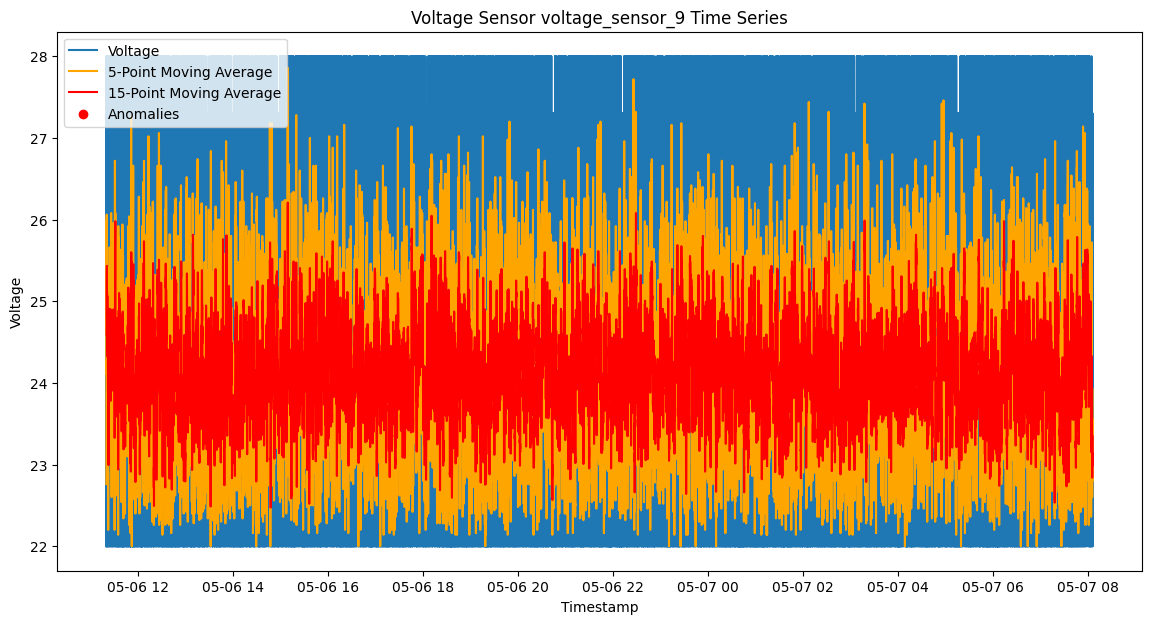

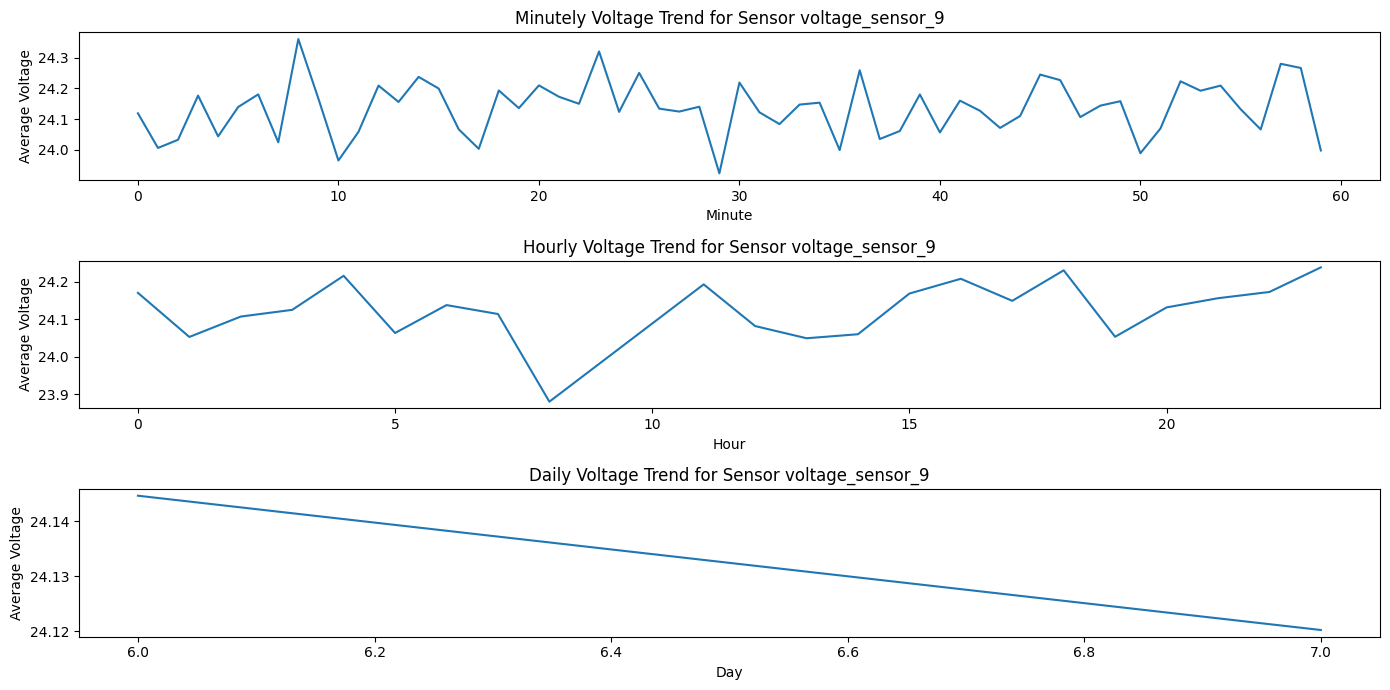

Minutely Voltage Trend for Sensor voltage_sensor_9:
 minute
0     24.118689
1     24.005463
2     24.032161
3     24.176633
4     24.043358
5     24.139348
6     24.180597
7     24.023913
8     24.361576
9     24.167018
10    23.964524
11    24.058000
12    24.209351
13    24.155882
14    24.237922
15    24.199746
16    24.066497
17    24.002571
18    24.193350
19    24.135714
20    24.210000
21    24.172861
22    24.149881
23    24.320948
24    24.123399
25    24.250873
26    24.134063
27    24.124416
28    24.140284
29    23.922449
30    24.219347
31    24.121957
32    24.083495
33    24.147291
34    24.153545
35    23.998544
36    24.259382
37    24.034606
38    24.060859
39    24.180374
40    24.056186
41    24.160150
42    24.126914
43    24.070983
44    24.109976
45    24.245387
46    24.227273
47    24.106484
48    24.143796
49    24.158354
50    23.988208
51    24.069048
52    24.223333
53    24.192619
54    24.209291
55    24.132061
56    24.066093
57    24.280620
58    24.267

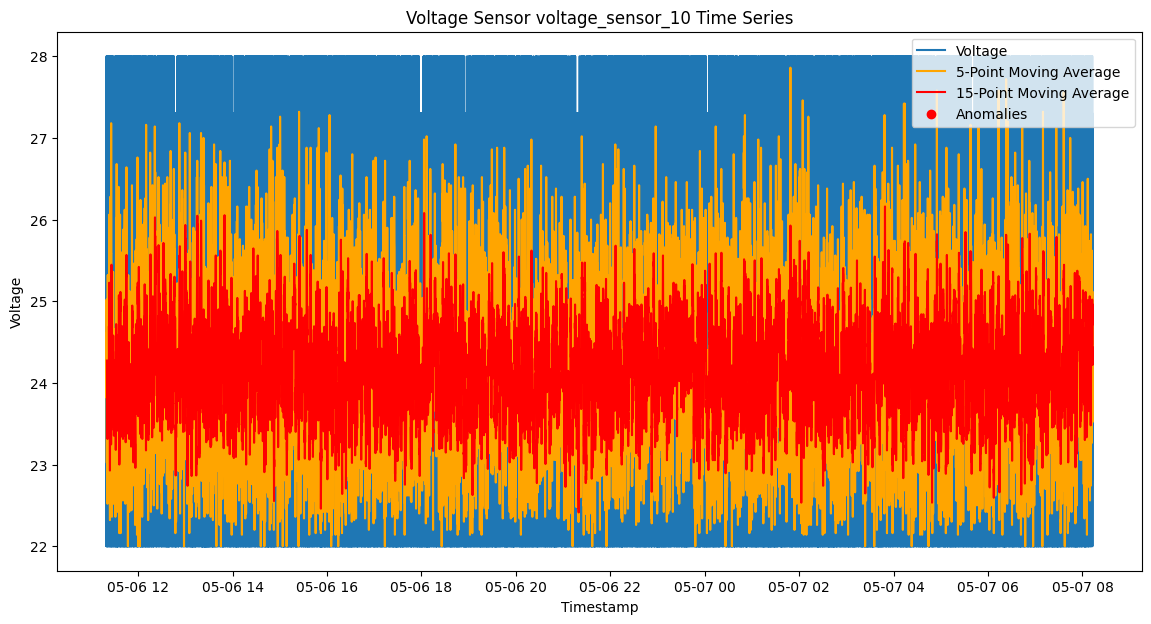

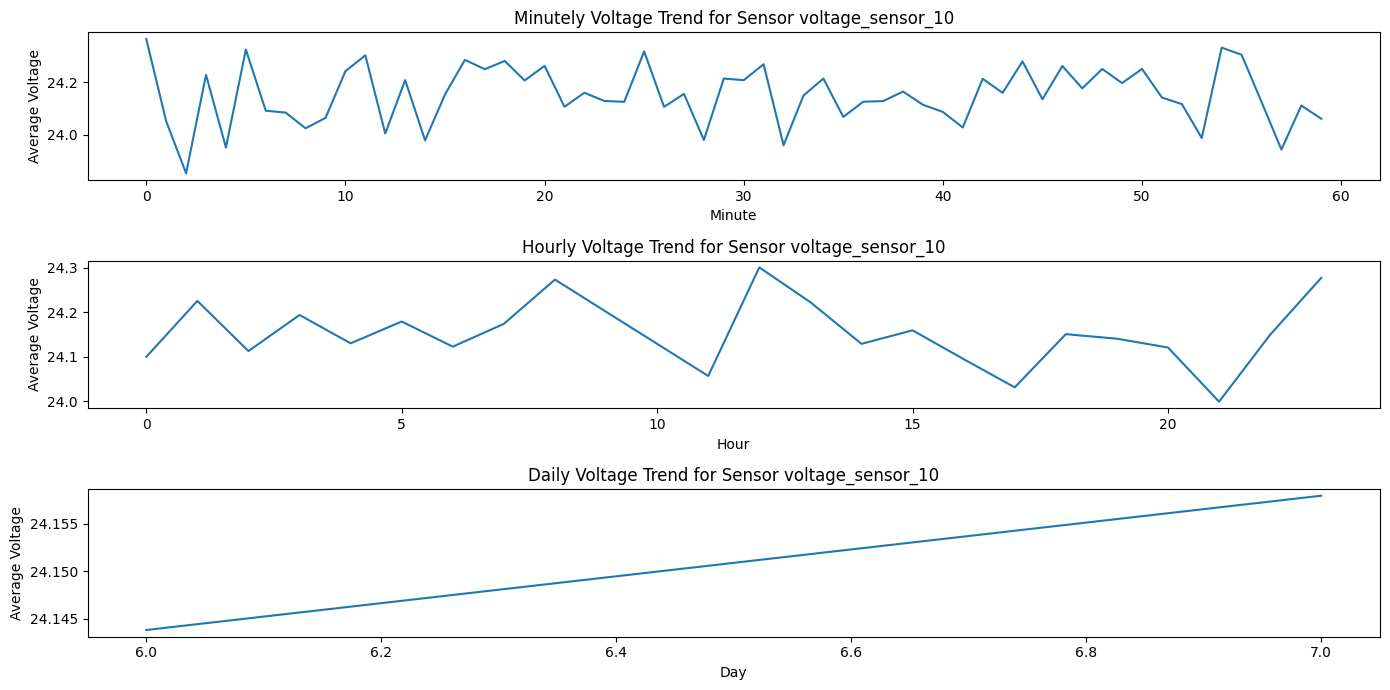

Minutely Voltage Trend for Sensor voltage_sensor_10:
 minute
0     24.363496
1     24.051309
2     23.853494
3     24.227561
4     23.951597
5     24.323515
6     24.091335
7     24.084112
8     24.024528
9     24.064039
10    24.241235
11    24.301804
12    24.004739
13    24.207634
14    23.978519
15    24.153056
16    24.284409
17    24.248925
18    24.280323
19    24.206045
20    24.261654
21    24.106311
22    24.159596
23    24.128434
24    24.124938
25    24.316500
26    24.106158
27    24.155065
28    23.980201
29    24.213534
30    24.207273
31    24.267775
32    23.960149
33    24.148913
34    24.213368
35    24.067711
36    24.125436
37    24.127820
38    24.164115
39    24.113953
40    24.086683
41    24.027595
42    24.212594
43    24.159250
44    24.278713
45    24.134772
46    24.261071
47    24.176131
48    24.249747
49    24.196287
50    24.250000
51    24.141432
52    24.116500
53    23.987654
54    24.330958
55    24.303769
56    24.124808
57    23.943655
58    24.11

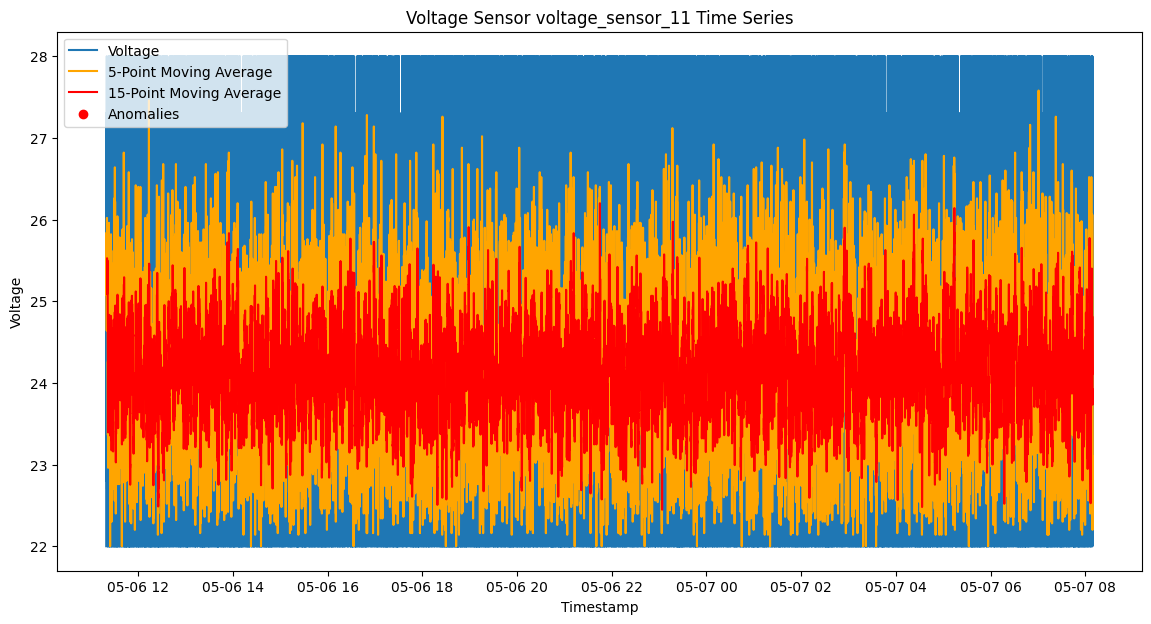

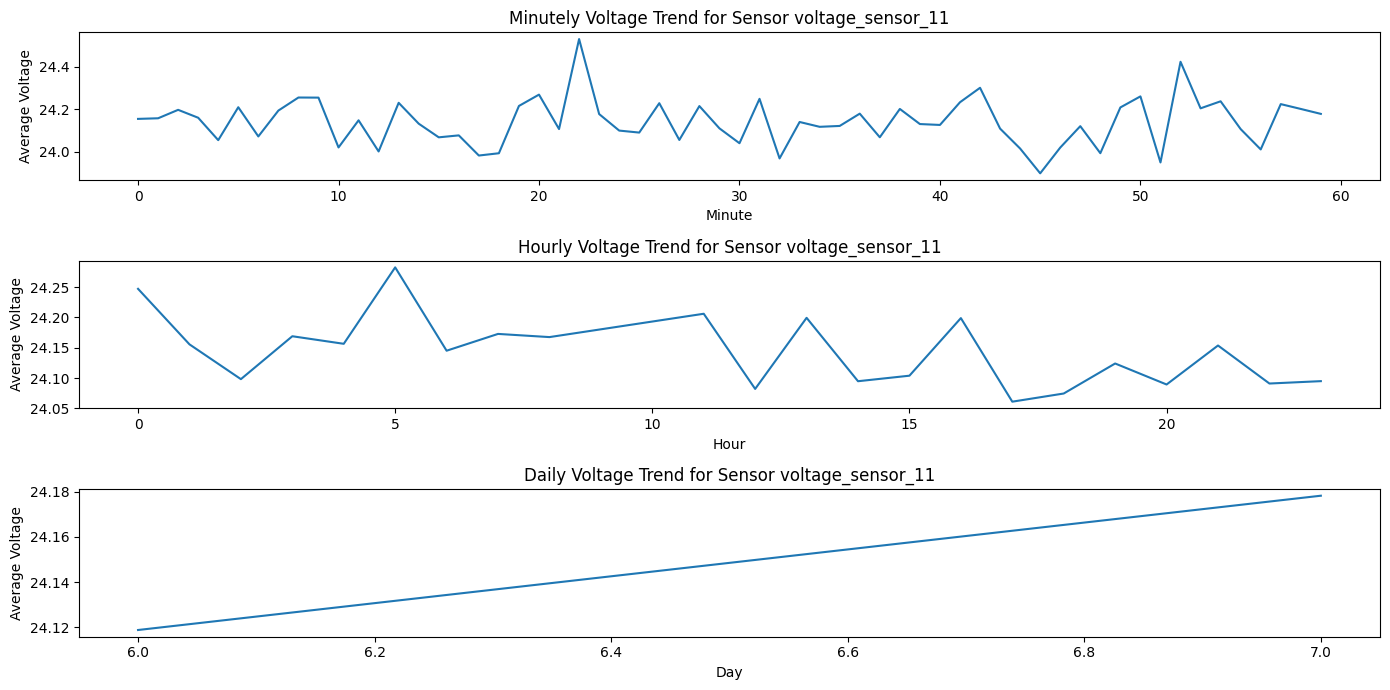

Minutely Voltage Trend for Sensor voltage_sensor_11:
 minute
0     24.153995
1     24.156848
2     24.196569
3     24.159322
4     24.053968
5     24.208789
6     24.071466
7     24.193069
8     24.254502
9     24.254005
10    24.019624
11    24.147273
12    24.000771
13    24.229589
14    24.131510
15    24.067268
16    24.076410
17    23.981644
18    23.992388
19    24.214842
20    24.268123
21    24.106147
22    24.529517
23    24.176733
24    24.098995
25    24.089598
26    24.227816
27    24.054887
28    24.214216
29    24.109547
30    24.039494
31    24.248329
32    23.967952
33    24.139401
34    24.116710
35    24.120813
36    24.178624
37    24.067482
38    24.200711
39    24.129698
40    24.125510
41    24.232282
42    24.300260
43    24.108229
44    24.014428
45    23.897872
46    24.019010
47    24.119765
48    23.992619
49    24.207868
50    24.259847
51    23.949118
52    24.422549
53    24.203667
54    24.236725
55    24.105941
56    24.010354
57    24.223499
58    24.20

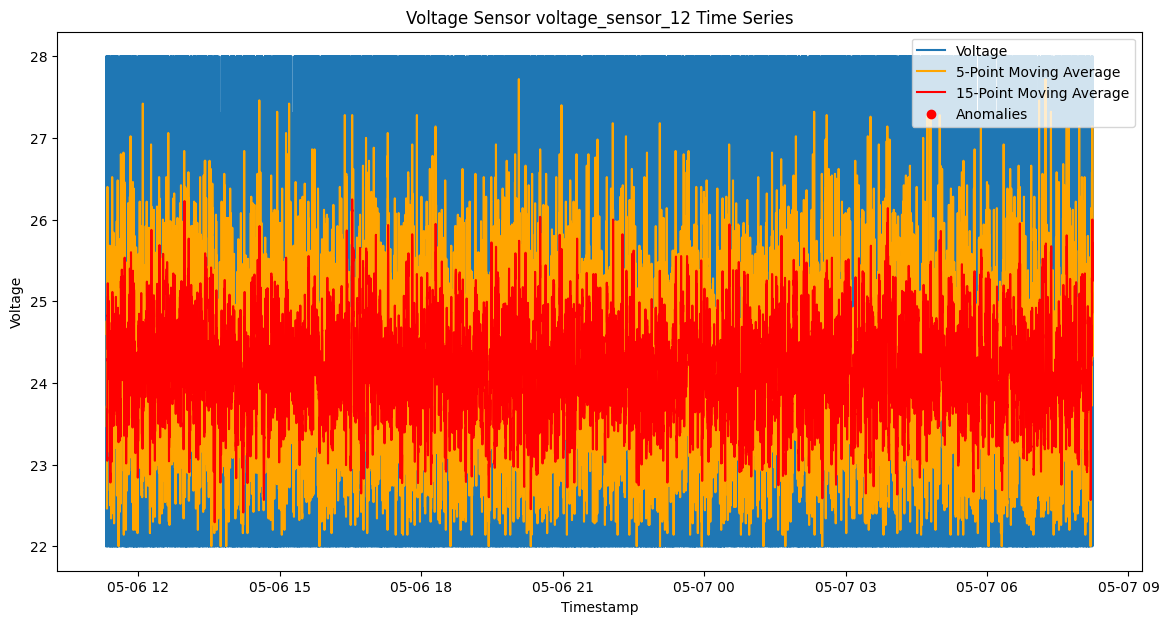

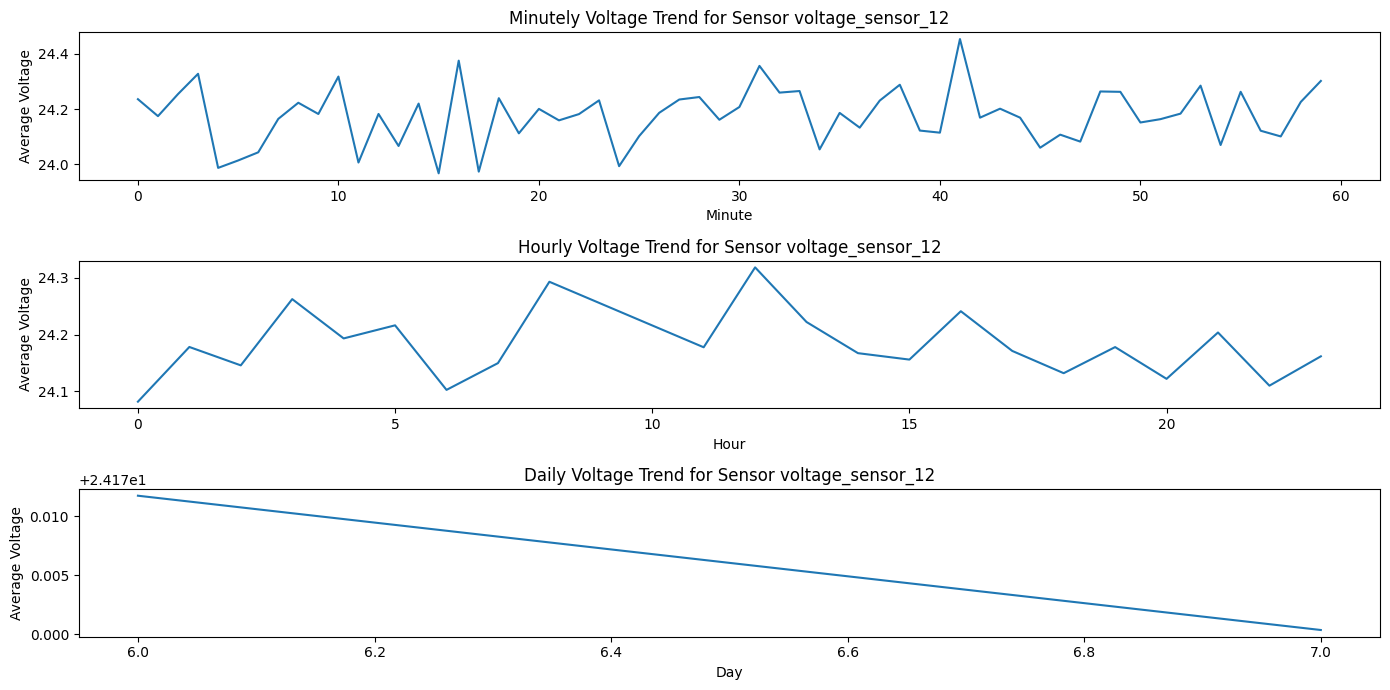

Minutely Voltage Trend for Sensor voltage_sensor_12:
 minute
0     24.235661
1     24.174250
2     24.254187
3     24.327559
4     23.986861
5     24.013766
6     24.043223
7     24.164251
8     24.222727
9     24.182045
10    24.317531
11    24.006281
12    24.182161
13    24.066154
14    24.219668
15    23.967109
16    24.375253
17    23.973247
18    24.239211
19    24.111990
20    24.200499
21    24.158942
22    24.181704
23    24.231387
24    23.993052
25    24.101956
26    24.186275
27    24.234414
28    24.243467
29    24.161140
30    24.207407
31    24.356219
32    24.259432
33    24.265185
34    24.053846
35    24.185930
36    24.132558
37    24.230612
38    24.287931
39    24.122005
40    24.114400
41    24.453401
42    24.168687
43    24.201232
44    24.168657
45    24.059897
46    24.107214
47    24.082031
48    24.263570
49    24.262260
50    24.151250
51    24.163307
52    24.183290
53    24.284672
54    24.069704
55    24.262371
56    24.121393
57    24.100761
58    24.22

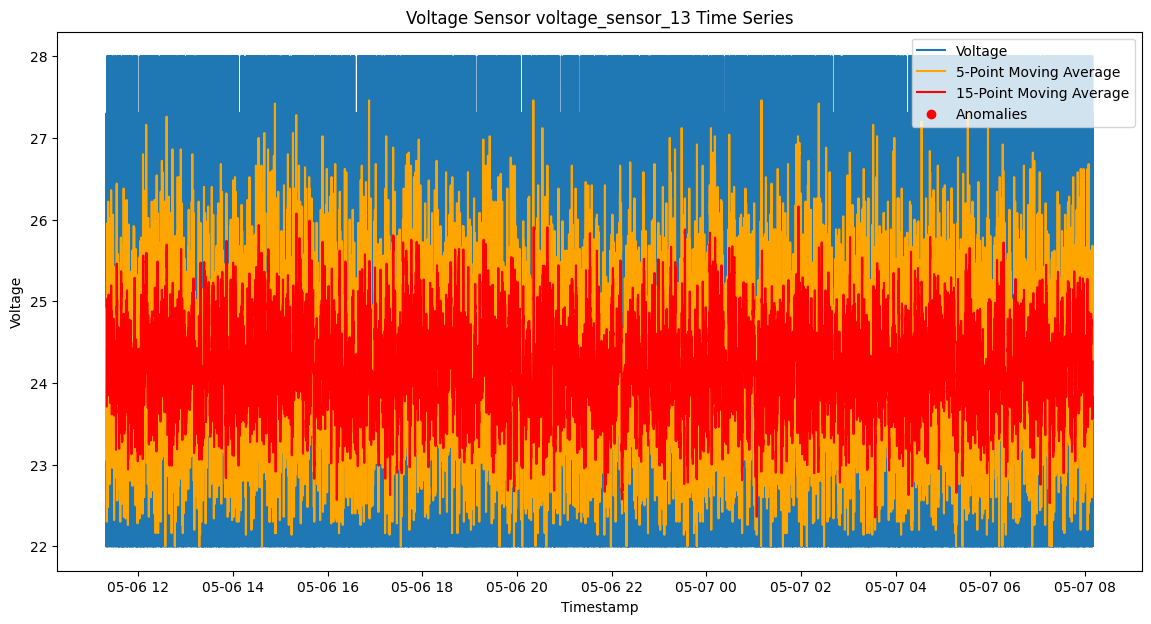

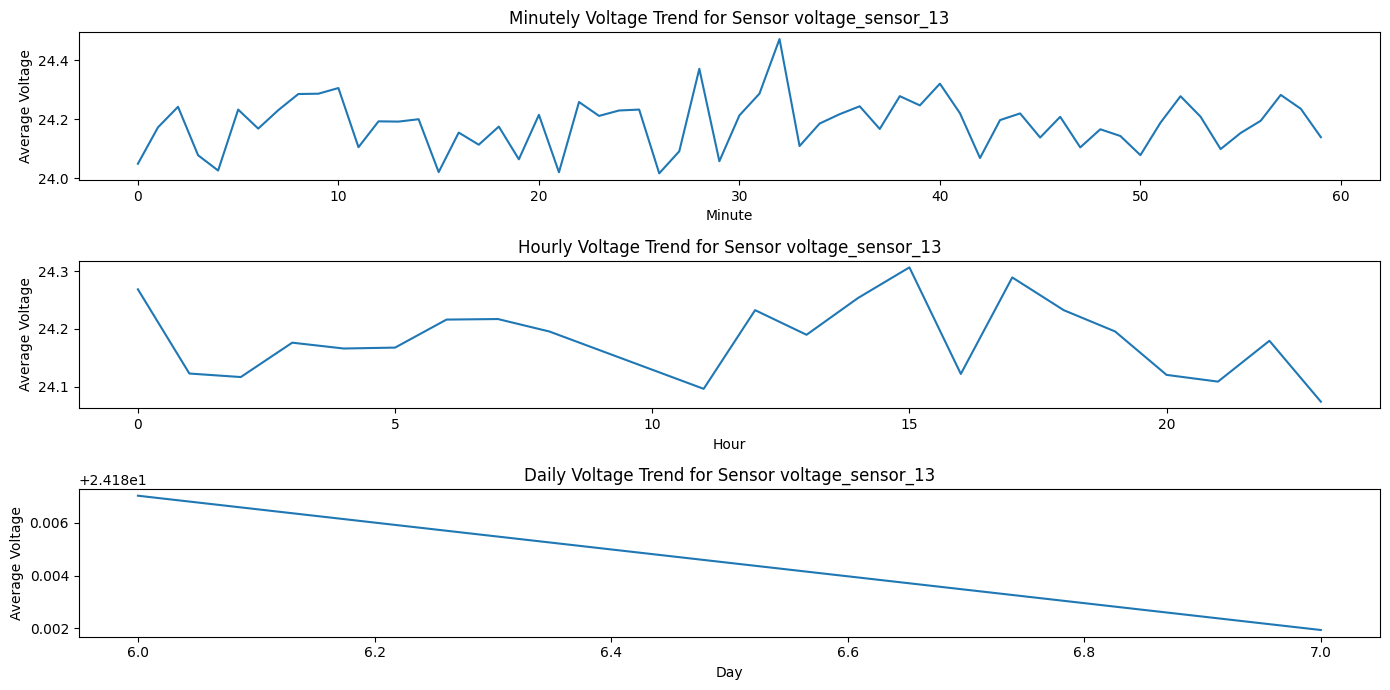

Minutely Voltage Trend for Sensor voltage_sensor_13:
 minute
0     24.049386
1     24.172705
2     24.242365
3     24.078173
4     24.026366
5     24.232911
6     24.168434
7     24.230958
8     24.285714
9     24.286765
10    24.305990
11    24.105426
12    24.193077
13    24.192225
14    24.200270
15    24.021053
16    24.155000
17    24.113838
18    24.175335
19    24.064428
20    24.215130
21    24.020494
22    24.258519
23    24.211511
24    24.229891
25    24.232933
26    24.016834
27    24.091517
28    24.371186
29    24.057971
30    24.213221
31    24.286957
32    24.472019
33    24.109367
34    24.185604
35    24.217370
36    24.244096
37    24.167233
38    24.278465
39    24.247188
40    24.320759
41    24.220647
42    24.068750
43    24.197349
44    24.219904
45    24.138257
46    24.208475
47    24.104762
48    24.166162
49    24.143447
50    24.078515
51    24.188361
52    24.278240
53    24.208883
54    24.099027
55    24.153598
56    24.195000
57    24.282653
58    24.23

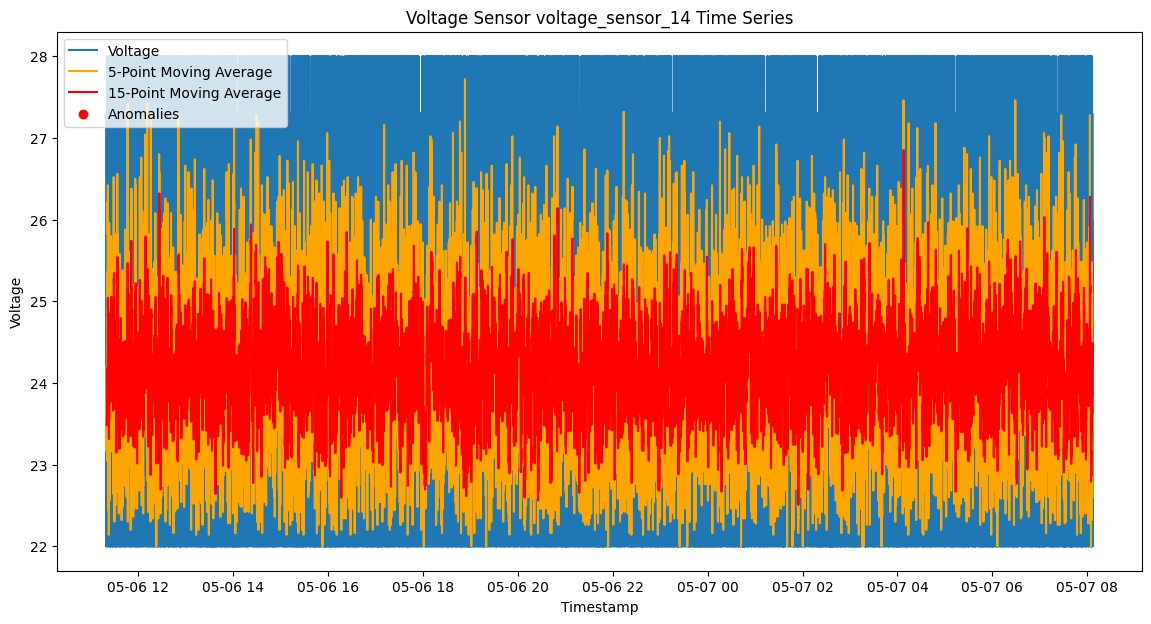

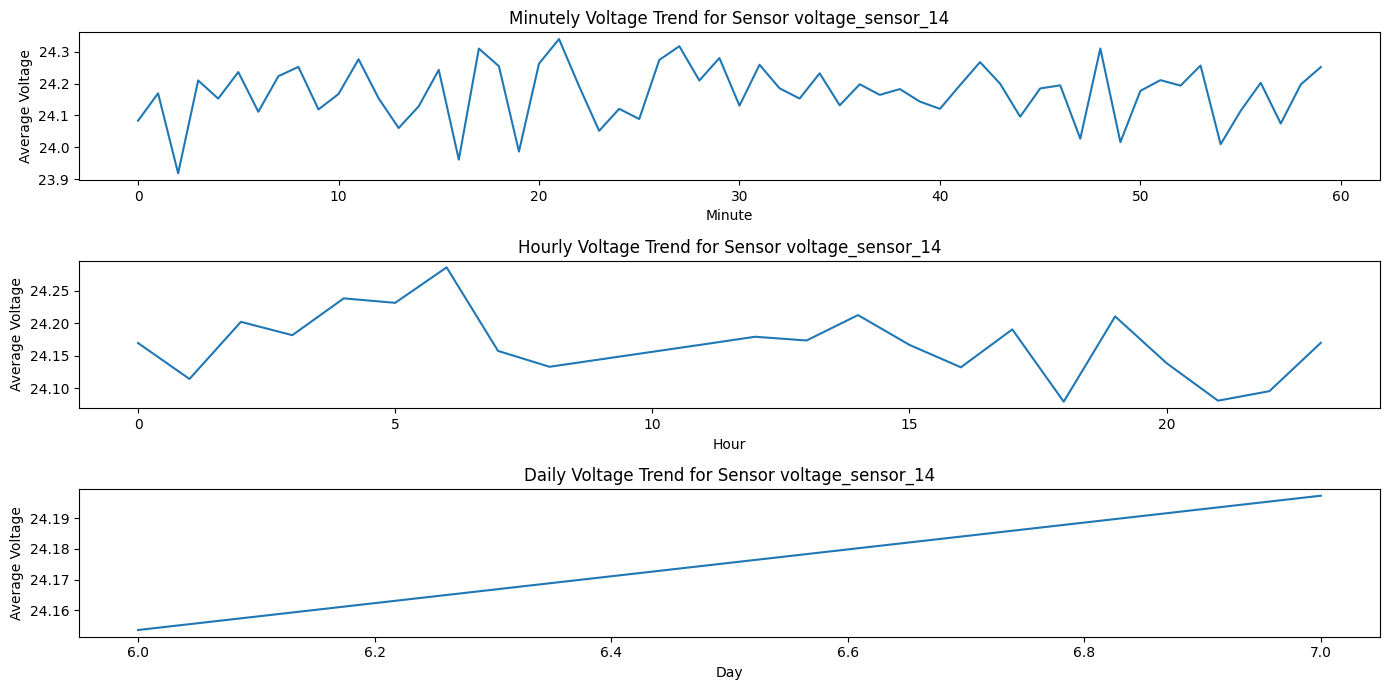

Minutely Voltage Trend for Sensor voltage_sensor_14:
 minute
0     24.083578
1     24.169668
2     23.918182
3     24.210219
4     24.152955
5     24.236496
6     24.111721
7     24.223467
8     24.252785
9     24.118966
10    24.167519
11    24.276676
12    24.154011
13    24.060519
14    24.128804
15    24.243342
16    23.961230
17    24.310215
18    24.254907
19    23.986616
20    24.262935
21    24.340241
22    24.192020
23    24.051786
24    24.120913
25    24.088860
26    24.274458
27    24.317708
28    24.209932
29    24.280605
30    24.130843
31    24.259413
32    24.185401
33    24.153218
34    24.232514
35    24.131971
36    24.198082
37    24.164796
38    24.182974
39    24.143669
40    24.120896
41    24.195227
42    24.267654
43    24.200000
44    24.096209
45    24.184975
46    24.194776
47    24.027094
48    24.310526
49    24.016184
50    24.177566
51    24.211111
52    24.193857
53    24.256892
54    24.009596
55    24.114536
56    24.202835
57    24.074750
58    24.19

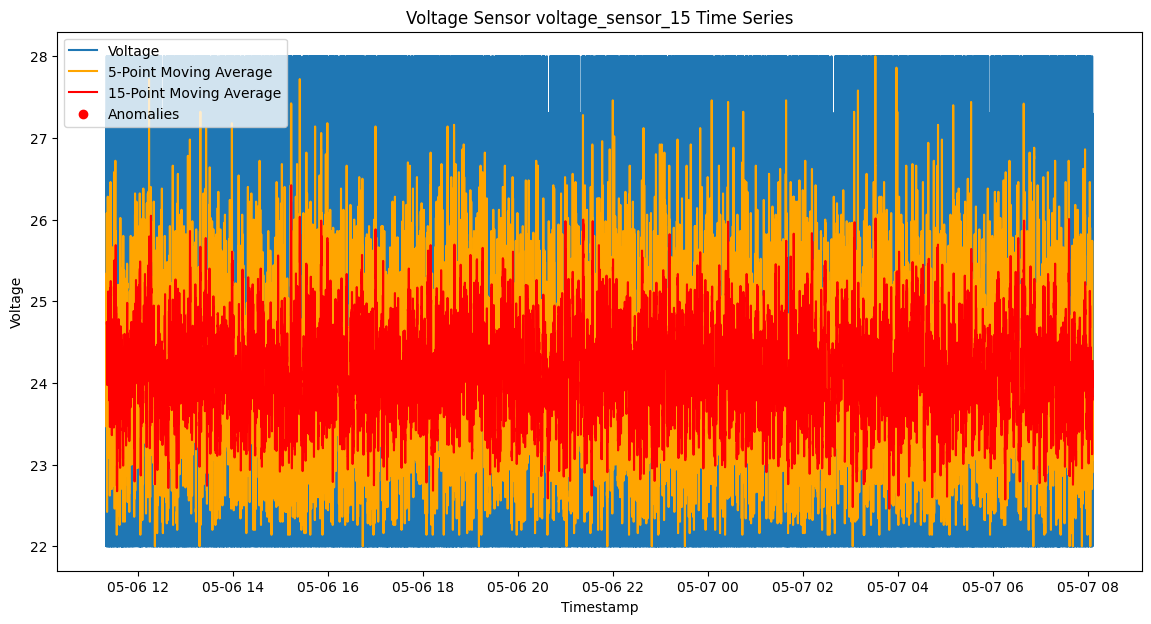

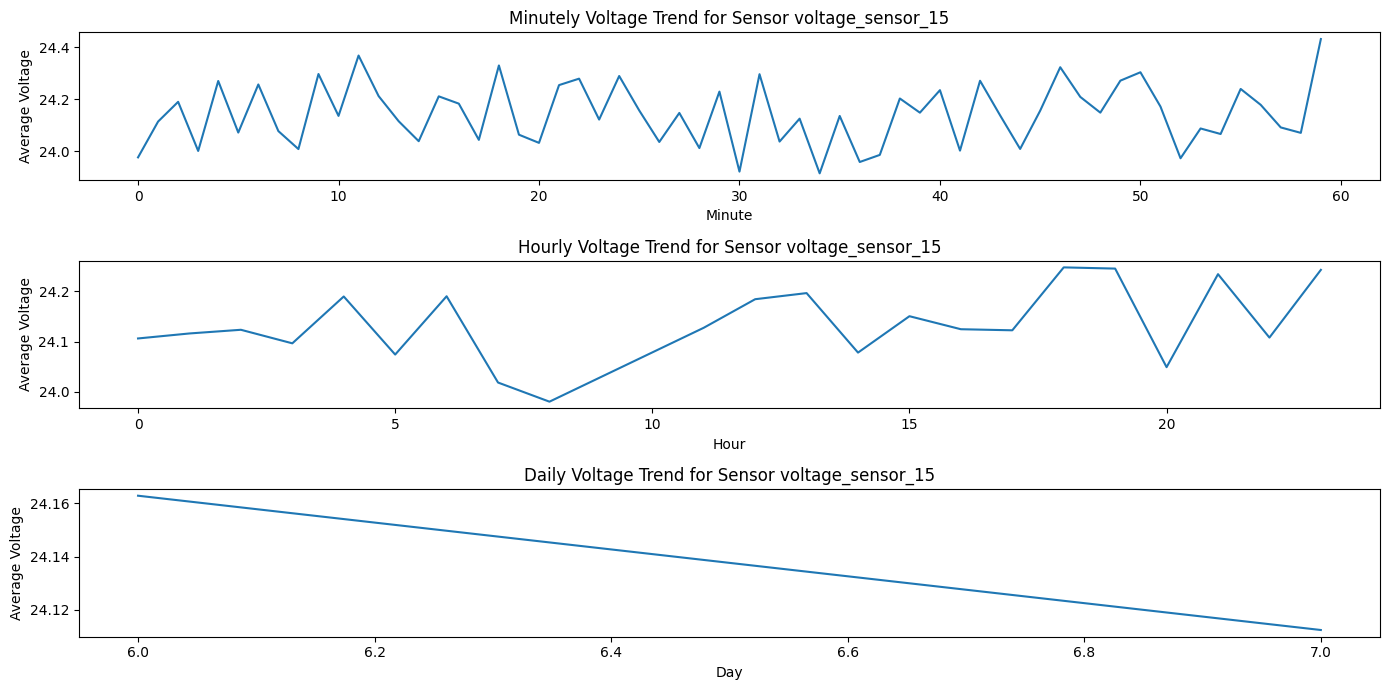

Minutely Voltage Trend for Sensor voltage_sensor_15:
 minute
0     23.975980
1     24.113682
2     24.189549
3     24.000699
4     24.269674
5     24.071393
6     24.256281
7     24.076986
8     24.007960
9     24.296456
10    24.135459
11    24.367448
12    24.211663
13    24.115000
14    24.038244
15    24.210598
16    24.182564
17    24.043307
18    24.329306
19    24.063198
20    24.031754
21    24.253846
22    24.278589
23    24.121357
24    24.288783
25    24.156325
26    24.035222
27    24.146835
28    24.011736
29    24.228814
30    23.921282
31    24.295761
32    24.036779
33    24.124873
34    23.914640
35    24.135208
36    23.958250
37    23.985500
38    24.202398
39    24.147891
40    24.234360
41    24.001946
42    24.270529
43    24.137621
44    24.008458
45    24.155528
46    24.322518
47    24.208458
48    24.147962
49    24.270951
50    24.303194
51    24.171324
52    23.972593
53    24.087097
54    24.065860
55    24.239062
56    24.177966
57    24.091111
58    24.07

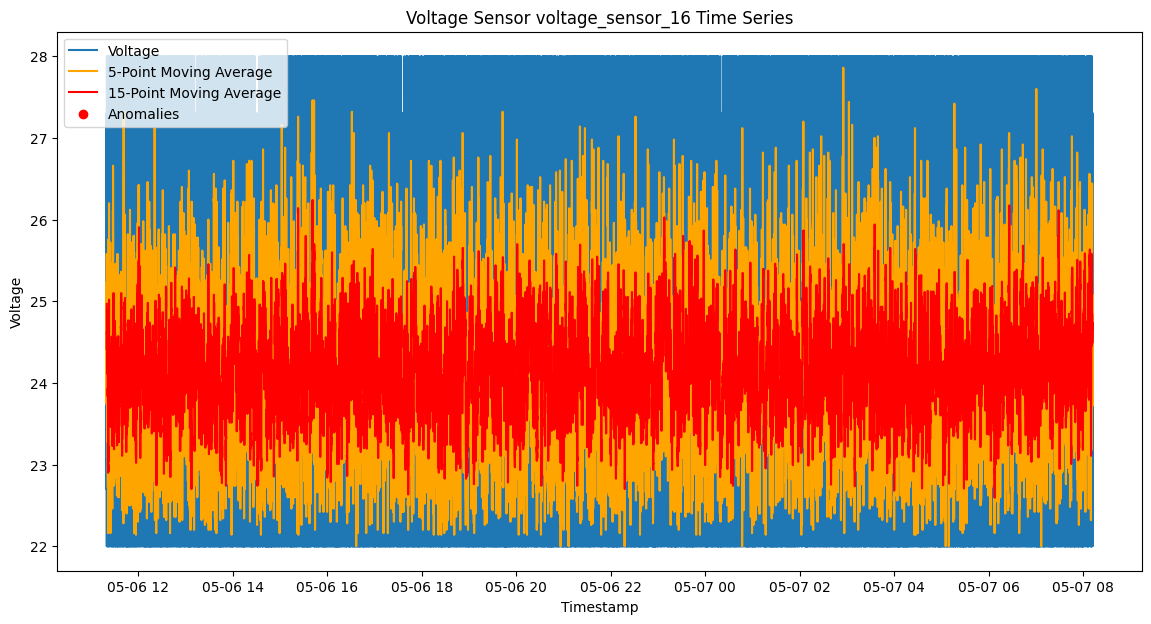

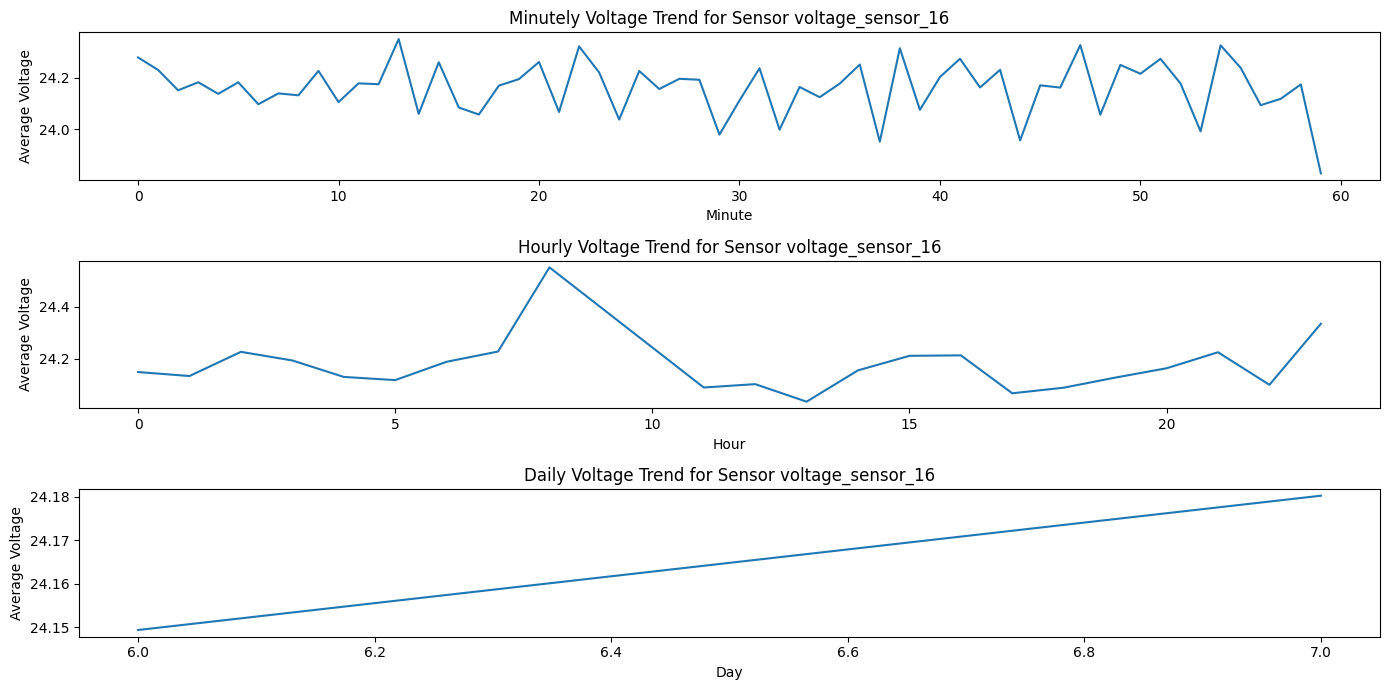

Minutely Voltage Trend for Sensor voltage_sensor_16:
 minute
0     24.278436
1     24.229975
2     24.150962
3     24.182152
4     24.137232
5     24.181980
6     24.096923
7     24.138918
8     24.131538
9     24.226225
10    24.105211
11    24.177889
12    24.174619
13    24.349737
14    24.059640
15    24.259606
16    24.084182
17    24.057067
18    24.169152
19    24.194474
20    24.260636
21    24.067085
22    24.321235
23    24.220241
24    24.037437
25    24.225917
26    24.155949
27    24.195545
28    24.191912
29    23.978961
30    24.111316
31    24.236408
32    23.998210
33    24.163819
34    24.124250
35    24.176790
36    24.250852
37    23.951613
38    24.314021
39    24.075194
40    24.202387
41    24.273282
42    24.162053
43    24.230273
44    23.956595
45    24.170252
46    24.161558
47    24.326303
48    24.056265
49    24.249340
50    24.215144
51    24.272993
52    24.177494
53    23.991852
54    24.325436
55    24.238095
56    24.093243
57    24.118052
58    24.17

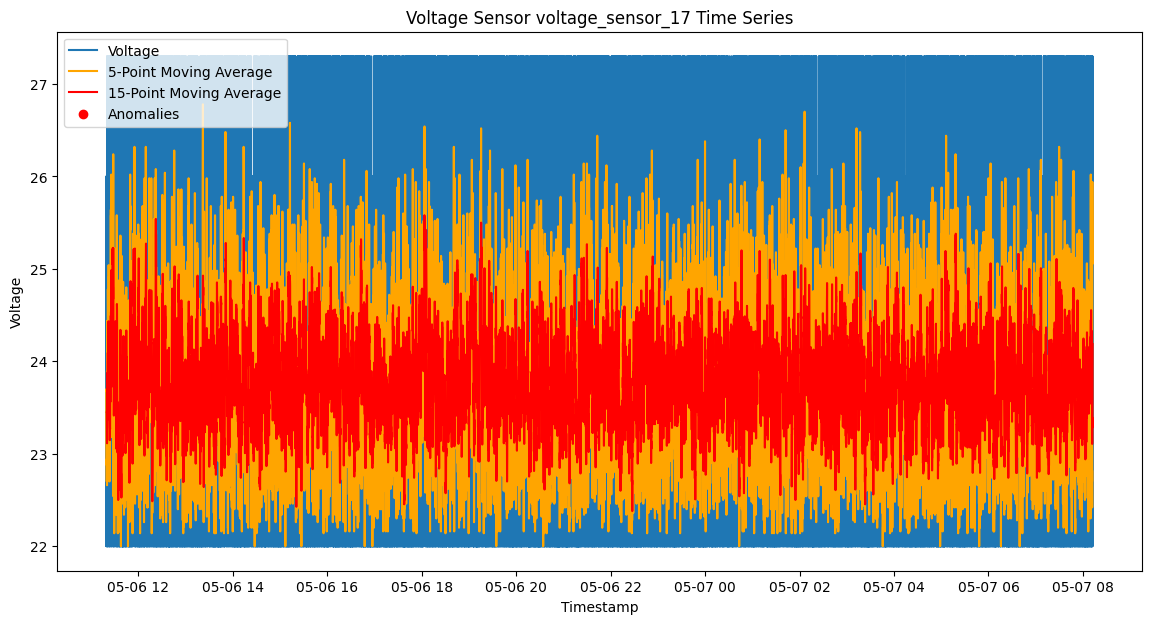

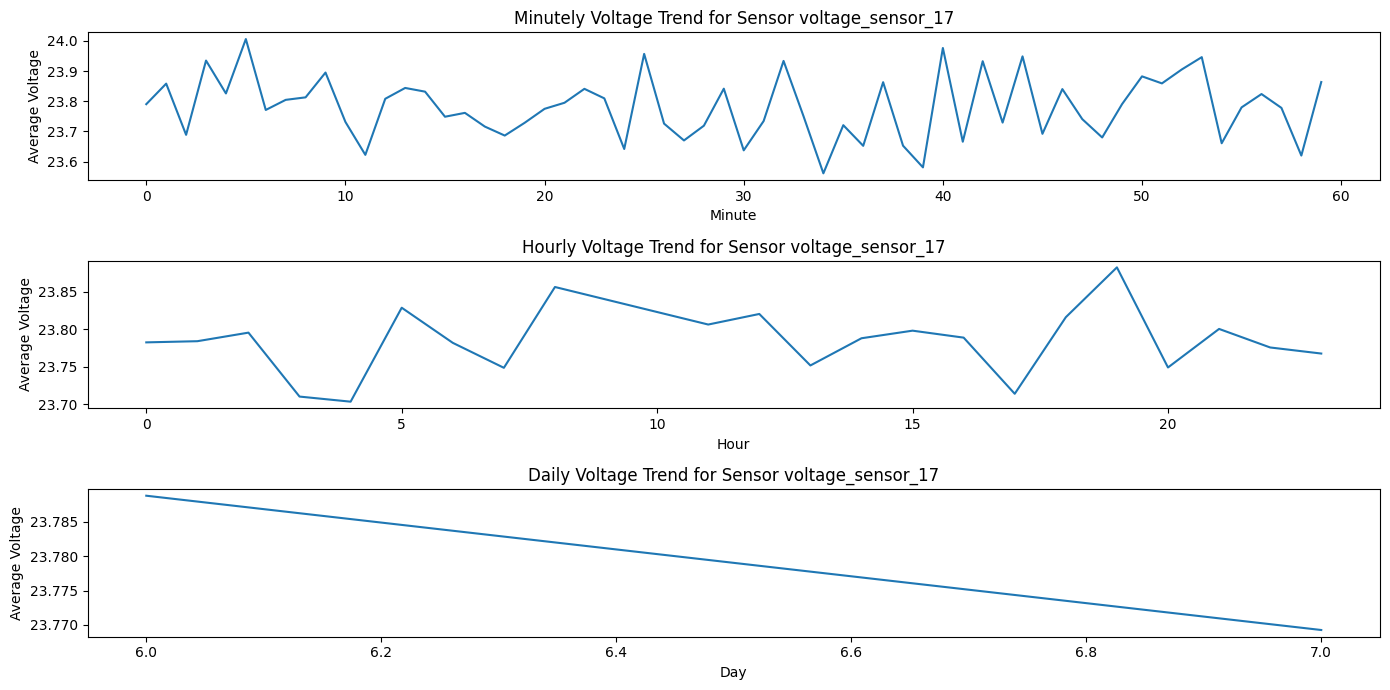

Minutely Voltage Trend for Sensor voltage_sensor_17:
 minute
0     23.790374
1     23.858445
2     23.688705
3     23.934930
4     23.825946
5     24.006301
6     23.771173
7     23.804658
8     23.812973
9     23.895211
10    23.731461
11    23.622312
12    23.808235
13    23.844160
14    23.831868
15    23.748732
16    23.761538
17    23.716109
18    23.686297
19    23.728610
20    23.774936
21    23.795028
22    23.841192
23    23.809635
24    23.641761
25    23.957062
26    23.725895
27    23.670079
28    23.718997
29    23.841753
30    23.637265
31    23.734400
32    23.933784
33    23.750933
34    23.561017
35    23.720690
36    23.652243
37    23.863248
38    23.652674
39    23.580789
40    23.976685
41    23.665854
42    23.932808
43    23.729301
44    23.948861
45    23.692068
46    23.840331
47    23.740761
48    23.679947
49    23.790765
50    23.882586
51    23.859249
52    23.905602
53    23.946296
54    23.660784
55    23.779722
56    23.823936
57    23.778056
58    23.62

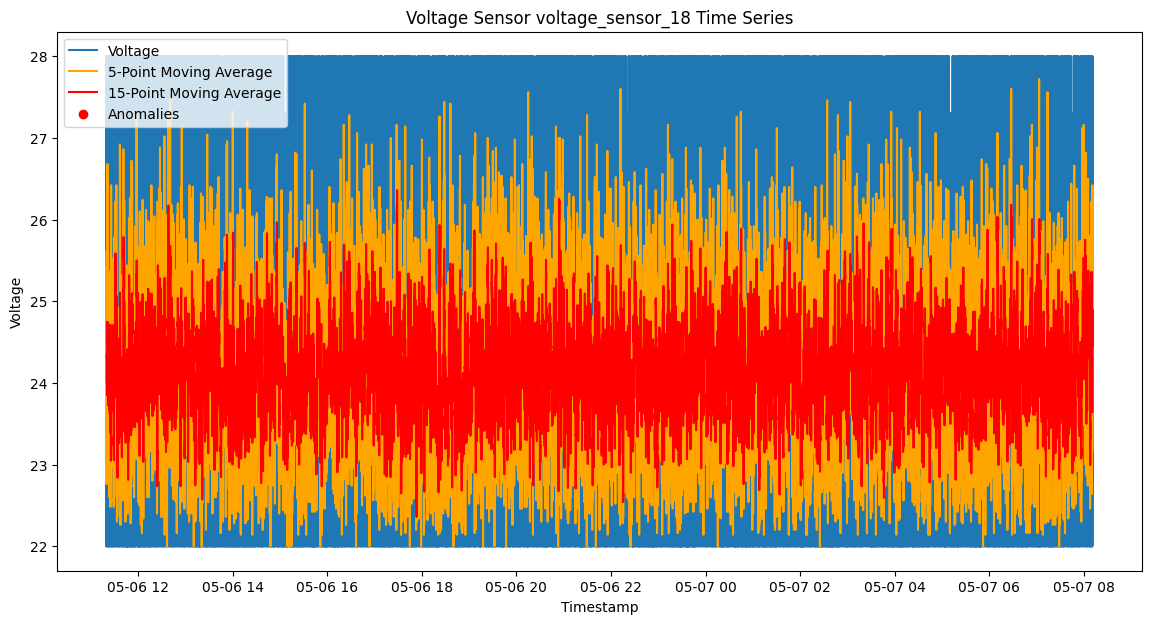

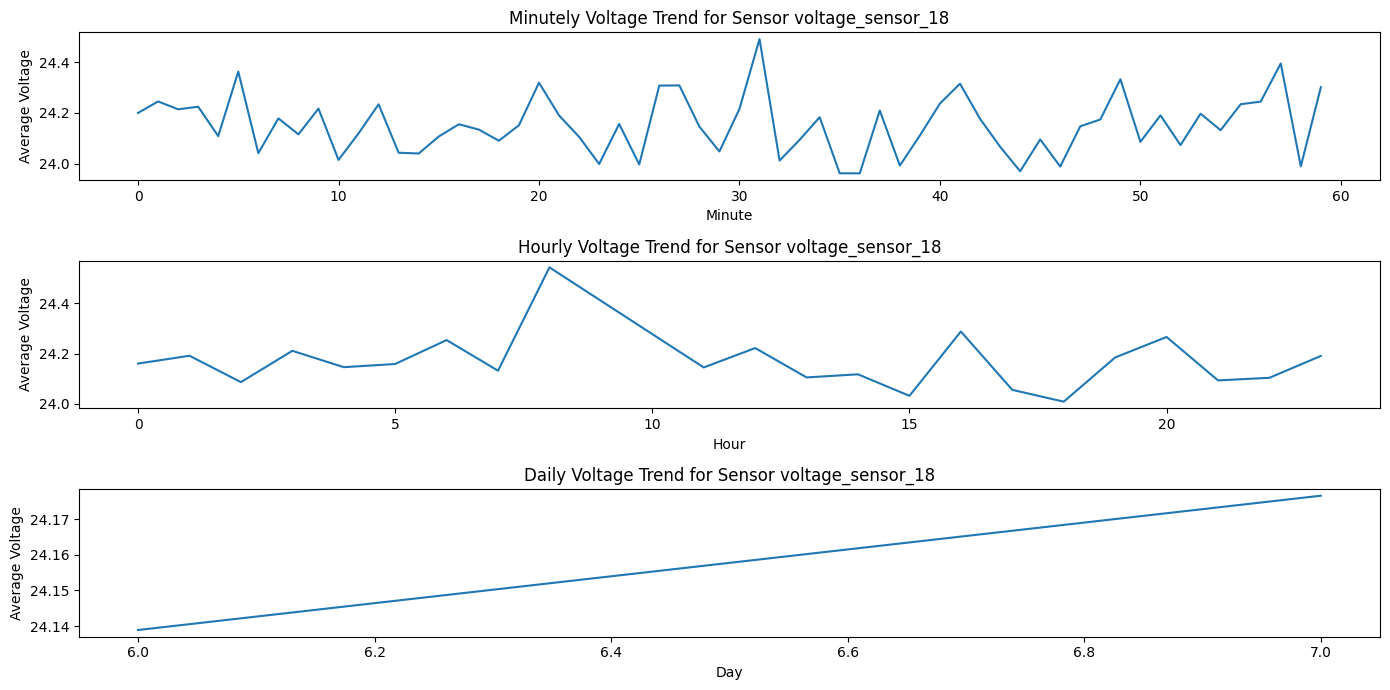

Minutely Voltage Trend for Sensor voltage_sensor_18:
 minute
0     24.200000
1     24.245408
2     24.214425
3     24.224455
4     24.108901
5     24.362879
6     24.041727
7     24.178589
8     24.115691
9     24.217157
10    24.015104
11    24.119588
12    24.234109
13    24.043467
14    24.040302
15    24.107162
16    24.155435
17    24.134500
18    24.090667
19    24.151597
20    24.319059
21    24.190394
22    24.105995
23    23.998997
24    24.156532
25    23.997150
26    24.307673
27    24.308511
28    24.146135
29    24.048418
30    24.216067
31    24.491045
32    24.012626
33    24.094074
34    24.183250
35    23.962338
36    23.962207
37    24.209630
38    23.992768
39    24.111340
40    24.237046
41    24.315233
42    24.176980
43    24.067179
44    23.970509
45    24.095567
46    23.989114
47    24.147368
48    24.174447
49    24.332658
50    24.086275
51    24.190526
52    24.073383
53    24.197059
54    24.132041
55    24.234286
56    24.244730
57    24.394915
58    23.98

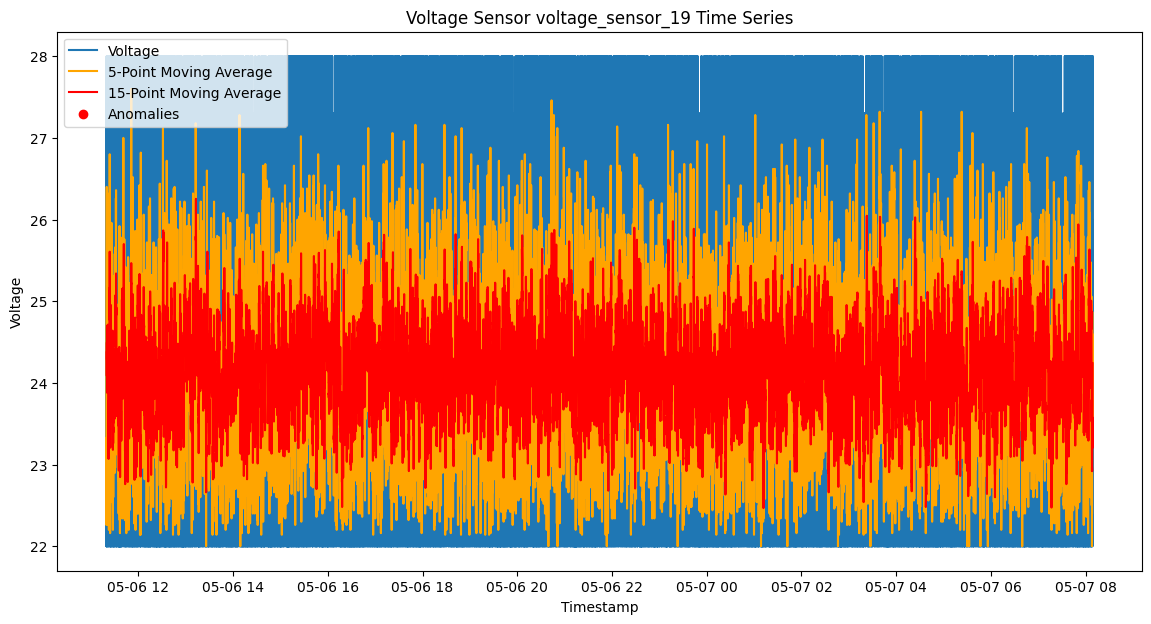

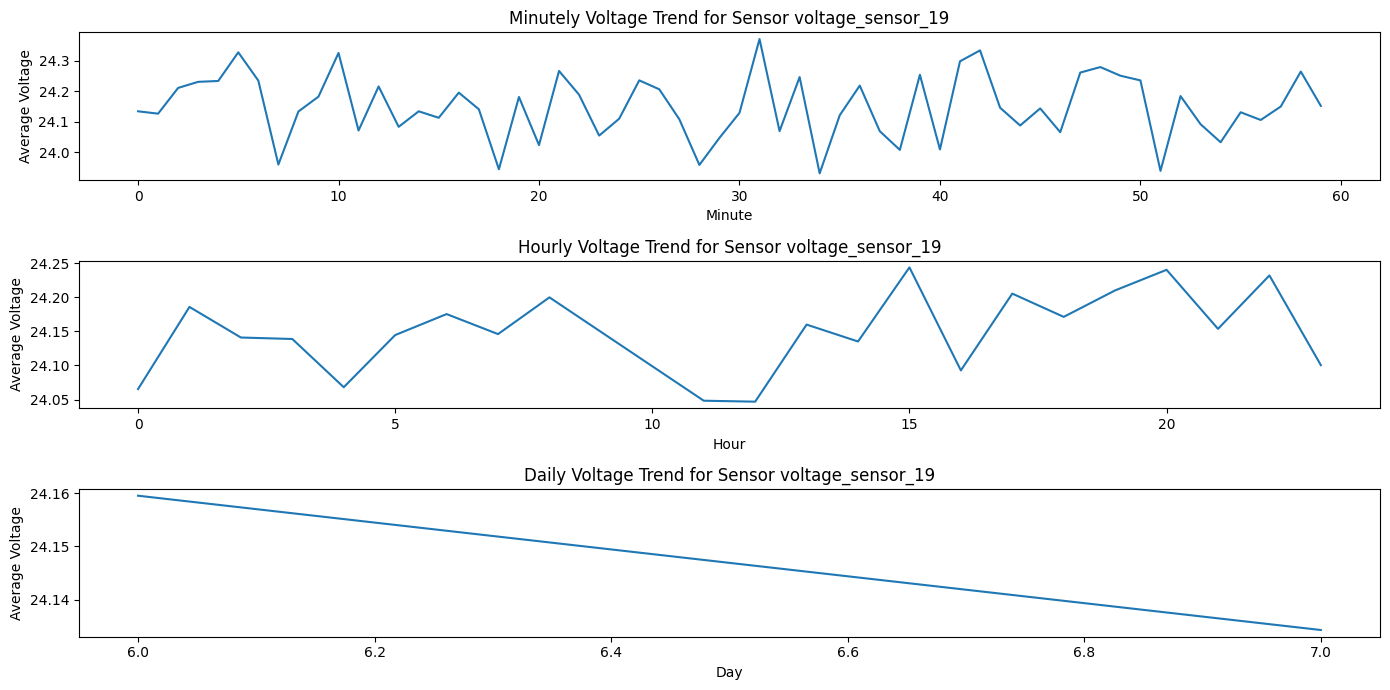

Minutely Voltage Trend for Sensor voltage_sensor_19:
 minute
0     24.134527
1     24.126786
2     24.211111
3     24.231034
4     24.233820
5     24.327654
6     24.235013
7     23.960194
8     24.133886
9     24.182552
10    24.325635
11    24.071618
12    24.215869
13    24.083684
14    24.134518
15    24.113317
16    24.195652
17    24.141176
18    23.944675
19    24.181407
20    24.023888
21    24.266667
22    24.188756
23    24.054950
24    24.110219
25    24.235891
26    24.206616
27    24.108421
28    23.958867
29    24.047301
30    24.129323
31    24.371178
32    24.069634
33    24.246579
34    23.931328
35    24.121446
36    24.218689
37    24.069270
38    24.008108
39    24.254034
40    24.009561
41    24.298289
42    24.333995
43    24.146193
44    24.088067
45    24.143951
46    24.066180
47    24.261404
48    24.279397
49    24.251106
50    24.235731
51    23.939394
52    24.184390
53    24.092252
54    24.033171
55    24.131358
56    24.106103
57    24.150120
58    24.26

In [67]:
mean_std_list = []
peak_voltage_list = []
low_voltage_list = []

# Iterate over each sensor
for sensor in data_dict['data']:
    df, tid, peak_voltage_times, low_voltage_times, empty_values_count, outliers_removed, anomalies_count, final_row_count, mean_voltage, std_dev = process_sensor_data(sensor, sunrise, sunset)

    # Print Results
    print(f"Sensor {tid}:")
    print(f"Number of Rows of Data: {final_row_count}")
    print(f"Number of Empty Values Removed: {empty_values_count}")
    print(f"Number of Outliers Removed: {outliers_removed}")
    print(f"Number of Potential Anomalies Detected: {anomalies_count}")

    plot_time_series(df, tid)
    minute_trend, hourly_trend, daily_trend = plot_trends(df, tid)

    print(f"Minutely Voltage Trend for Sensor {tid}:\n", minute_trend)
    print(f"Hourly Voltage Trend for Sensor {tid}:\n", hourly_trend)
    print(f"Daily Voltage Trend for Sensor {tid}:\n", daily_trend)

    daylight_voltage, nighttime_voltage = analyze_voltage(df, tid, peak_voltage_times, low_voltage_times)

    mean_value, std_dev = calculate_statistics(df, tid)

    # Update summary stats
    total_empty_values_removed += empty_values_count
    total_outliers_removed += outliers_removed
    total_anomalies_count += anomalies_count

    # Append results to lists for CSV output
    mean_std_list.append([tid, mean_value, std_dev])

    for i, (timestamp, voltage) in enumerate(zip(peak_voltage_times['timestamp'], peak_voltage_times['voltage'])):
        peak_voltage_list.append([tid, timestamp, voltage])

    for i, (timestamp, voltage) in enumerate(zip(low_voltage_times['timestamp'], low_voltage_times['voltage'])):
        low_voltage_list.append([tid, timestamp, voltage])

    print("\n")

# Save results to CSV files
mean_std_df = pd.DataFrame(mean_std_list, columns=['Sensor ID', 'Mean Voltage', 'Standard Deviation'])
mean_std_df.to_csv('mean_std_values.csv', index=False)

peak_voltage_df = pd.DataFrame(peak_voltage_list, columns=['Sensor ID', 'Peak Voltage Time', 'Peak Voltage Value'])
peak_voltage_df.to_csv('peak_voltage_times.csv', index=False)

low_voltage_df = pd.DataFrame(low_voltage_list, columns=['Sensor ID', 'Low Voltage Time', 'Low Voltage Value'])
low_voltage_df.to_csv('low_voltage_times.csv', index=False)

# Print total statistics
print("Total Statistics:")
print(f"Total Empty Values Removed: {total_empty_values_removed}")
print(f"Total Outliers Removed: {total_outliers_removed}")
print(f"Total Potential Anomalies Detected: {total_anomalies_count}")
